#Detecting Hate Speech in Tweets

**Team:** Zuzanna Matysiak, Zachary Cahoone, Amy Zhou 

**Project Mentor TA:** Haoyu Wang

This notebook is a continuation of the project using Hatebase as the bag of words.


# Import libraries and datasets

In this section, we imported Davidson dataset and also bag of words of bad words. We tokonized tweets using TweetTokenizer from nltk. We also performed initial preprocessing of the data to add a column for each bad word from the bag.

In [8]:
import pandas as pd
from nltk.tokenize import TweetTokenizer
import csv
import urllib
import regex as re

In [9]:
!pip install sklearn

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In this part of the code, we will get our datasets. 

Note that for Davidson, class label for majority of CF users corresponds to: 0 - hate speech 1 - offensive language 2 - neither.

In [11]:
# Import Davidson dataset
url_hate_speech_data = "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv"
df_davidson = pd.read_csv(url_hate_speech_data)
df_davidson

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [12]:
# Import Waseem
url_hate_speech_data_waseem = "https://raw.githubusercontent.com/zuziamatysiak/cis419-hate-speech/main/data/df_waseem_preprocessed.csv"
df_waseem = pd.read_csv(url_hate_speech_data_waseem, sep=' ')
df_waseem

,Unnamed: 0,text,class_label
0,0,Drasko they didn't cook half a bird you idiot ...,racism
1,1,Hopefully someone cooks Drasko in the next ep ...,racism
2,3,of course you were born in serbia...you're as ...,racism
3,4,These girls are the equivalent of the irritati...,racism
4,5,RT @YesYoureRacist: At least you're only a tin...,racism
...,...,...,...
2738,2768,"RT @Superjutah: @MT8_9 £34,000 is £9000 above ...",sexism
2739,2769,RT @DufresneFrank: “@gabystama: @DufresneFrank...,sexism
2740,2770,RT @BoycottBrandy: @ActionFlickDoc this person...,sexism
2741,2771,RT @Lyall: Patriarchy™ will expel me if I divu...,sexism


In [13]:
# Import Founta dataset
df_founta = pd.read_excel('/content/hatespeech_text_label_vote.xlsx')
df_founta

,text,class_label
0,Beats by Dr. Dre urBeats Wired In-Ear Headphon...,spam
1,RT @Papapishu: Man it would fucking rule if we...,abusive
2,It is time to draw close to Him &#128591;&#127...,normal
3,if you notice me start to act different or dis...,normal
4,"Forget unfollowers, I believe in growing. 7 ne...",normal
...,...,...
99991,RT @shangros: my fucking queen https://t.co/wa...,abusive
99992,#Osteporosis treated with #PEMF - rebuild bone...,normal
99993,@LGUSAMobile why does my phone screen keeps fl...,normal
99994,#bigdata vs. #reality ... but equally applies ...,normal


# Preprocessing of the data.
In this section we will explore various preprocessing methods of the data. 

This is a function that preprocesses the data in the following way: it drops the Unnamed:0 column, get rids of RT and mentiones in the data. 

In [14]:
def preprocessing_method1(df, col_name):
  df = df.drop(["Unnamed: 0"], axis = 1)
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(x))) # removes retweets
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'(@[A-Za-z0-9-_]+)', '', str(x))) # removes mentions
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'[^\w\s]','', str(x))) # remove punctuation
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'^\d+\s|\s\d+\s|\s\d+$', ' ', str(x))) # remove digits
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'\s\s+', ' ', str(x))) # remove unncessary spaces
  return df

In [15]:
def preprocessing_method2(df, col_name):
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(x))) # removes retweets
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'(@[A-Za-z0-9-_]+)', '', str(x))) # removes mentions
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'[^\w\s]','', str(x))) # remove punctuation
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'^\d+\s|\s\d+\s|\s\d+$', ' ', str(x))) # remove digits
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'\s\s+', ' ', str(x))) # remove unncessary spaces
  return df

In [16]:
def preprocessing_method_minimal(df, col_name):
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'^\d+\s|\s\d+\s|\s\d+$', ' ', str(x))) # remove digits
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'\s\s+', ' ', str(x))) # remove unncessary spaces
  return df 

# Tokenizing  

We will define functions that will help us with tokenizng the data using TweetTokenizer(). 

In [17]:
def tokenize_method1(df, col_name):
   tweet_tokenizer = TweetTokenizer()
   df[col_name] = df[col_name].map(lambda x: tweet_tokenizer.tokenize(x))
   return df

In [18]:
def custom_tokenize(text): # For Waseem as it required special treatment for not string instances
  tweet_tokenizer = TweetTokenizer()
  if not(isinstance(text, str)):
    text = ''
  return tweet_tokenizer.tokenize(text)

# Bag of words
In this section we will explore various bags of words. 

The first one we will use is the same one used in te original paper.

In [19]:
words = []
url_hate_words = "https://raw.githubusercontent.com/zuziamatysiak/cis419-hate-speech/main/data/hatebase.txt"
bag_of_words = pd.read_csv(url_hate_words)
for i, row in bag_of_words.iterrows():
  words.append(row[0])

A function to modify dataframe to account for the bag of words.

In [20]:
def add_bad_words(df, label):
  for word in words:
    df[word] = df[label].map(lambda x: 1 if word in x else 0)

In [21]:
# TODO (Zach): use hatebase as bag of words

# Preprocessing Datasets for Training
We will start with preprocessing the Davidson dataset. 

#### Davidson Preprocessing for Training

In [22]:
df_davidson = preprocessing_method1(df_davidson, "tweet")
df_davidson

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,As a woman you shouldnt complain about cleani...
1,3,0,3,0,1,boy dats coldtyga dwn bad for cuffin dat hoe ...
2,3,0,3,0,1,Dawg RT You ever fuck a bitch and she start t...
3,3,0,2,1,1,she look like a tranny
4,6,0,6,0,1,The shit you hear about me might be true or i...
...,...,...,...,...,...,...
24778,3,0,2,1,1,yous a muthafin lie right His TL is trash Now ...
24779,3,0,1,2,2,youve gone and broke the wrong heart baby and ...
24780,3,0,3,0,1,young buck wanna eat dat nigguh like I aint fu...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [23]:
df_davidson.to_csv('df_davs.csv', index=False, sep=' ')

In [24]:
df_davidson = tokenize_method1(df_davidson, "tweet")

In [25]:
add_bad_words(df_davidson, "tweet")
df_davidson

,count,hate_speech,offensive_language,neither,class,tweet,africoon,alligator bait,anchor baby,anchor babies,ape,bamboo coon,banjo lips,beach nigger,beaner baby,beaner babies,beaner,bitch,bitches,black dago,blaxican,blue gum,bog hopper,bog jumper,bog trotter,bogan,bohunk,boojie,book book,boon,booner,boong,boonga,boonie,bootlip,border bunny,border hopper,border jumper,brass ankle,buckethead,...,whorientals,wigga,wiggas,wigger,wiggerette,wiggerettes,wiggers,wog,wogs,wops,wopspeak,yank,yankee,yanks,yard ape,yardie,yardies,yellow bone,yellow bones,yellow invader,yellowhammer,yid,yids,yob,yobbo,yobbos,yobs,yokel,yokels,zigabo,zigabos,zio,ziojew,ziojews,zionazi,zip,zipperhead,zippohead,zog,zog lover
0,3,0,0,3,2,"[As, a, woman, you, shouldnt, complain, about,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,0,3,0,1,"[boy, dats, coldtyga, dwn, bad, for, cuffin, d...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,3,0,1,"[Dawg, RT, You, ever, fuck, a, bitch, and, she...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,2,1,1,"[she, look, like, a, tranny]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,0,6,0,1,"[The, shit, you, hear, about, me, might, be, t...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,3,0,2,1,1,"[yous, a, muthafin, lie, right, His, TL, is, t...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24779,3,0,1,2,2,"[youve, gone, and, broke, the, wrong, heart, b...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24780,3,0,3,0,1,"[young, buck, wanna, eat, dat, nigguh, like, I...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24781,6,0,6,0,1,"[youu, got, wild, bitches, tellin, you, lies]",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
# Defining which classes we will be dropping when testing
labels_davidson = ["count", "hate_speech", "offensive_language", "neither", "class", "tweet"]
label_davidson = "class"

Let's do some word frequency distribution analysis to see the relation between our Davidson dataset and bag of words that we just used. 

In [27]:
# Get bad words from the tweets to see their frequency distribution 
def get_bad_words(df, l):
  count_of_words = df[l].sum()
  count_of_words = [x for x in count_of_words if x in words]
  return count_of_words

In [28]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
# plot histogram of bad words in the specified dataset
def plot_bad_words_histogram(count_of_words):
  counts = Counter(count_of_words)
  labels, values = zip(*counts.items())
  indices = np.arange(len(labels))
  bar_width = 0.2
  plt.bar(indices, values)
  plt.xticks(indices + bar_width, labels, rotation="vertical")
  plt.title("Bad words frequency in Davidson dataset tweets overall")
  plt.show()

In [29]:
davidson_count_of_words = get_bad_words(df_davidson, "tweet")
print(davidson_count_of_words[:30])

['hoe', 'bitch', 'tranny', 'bitch', 'bitch', 'bitches', 'bitch', 'bitch', 'bitch', 'bitch', 'bitches', 'bitch', 'bitch', 'nigga', 'bitch', 'bitch', 'bitches', 'bitch', 'bitch', 'bitch', 'bitch', 'bitch', 'pussy', 'hoe', 'pussy', 'pussy', 'bitch', 'bitch', 'bitch', 'bitch']


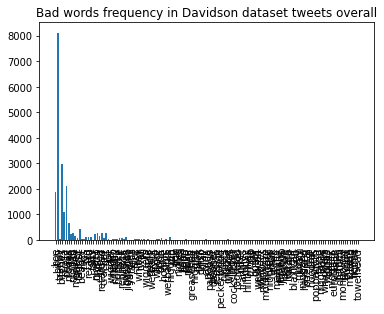

In [30]:
plot_bad_words_histogram(davidson_count_of_words)

We will also use WordCloud to get a better sense of the preprocessed dataset's mostly frequently used words.

In [31]:
from wordcloud import WordCloud
def generate_word_cloud(count_of_words):
  wordcloud = WordCloud(max_font_size=50, background_color="white", collocations=False).generate(' '.join(count_of_words))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

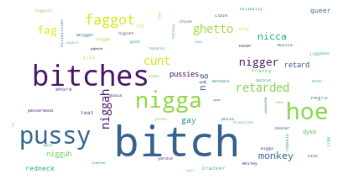

In [32]:
generate_word_cloud(davidson_count_of_words)

In the original paper for the Davidson they also split the predictions based on labels, so they made predictions for offensive language and hate speech separately too. Let's start with hate speech. Let's have 0 correspond to hate speech and 1 correspond to not hate speech. 

In [33]:
df_dav_hs = df_davidson
df_dav_hs['class'] = df_dav_hs['class'].map({0: 0, 1: 1, 2: 1})
df_dav_hs

,count,hate_speech,offensive_language,neither,class,tweet,africoon,alligator bait,anchor baby,anchor babies,ape,bamboo coon,banjo lips,beach nigger,beaner baby,beaner babies,beaner,bitch,bitches,black dago,blaxican,blue gum,bog hopper,bog jumper,bog trotter,bogan,bohunk,boojie,book book,boon,booner,boong,boonga,boonie,bootlip,border bunny,border hopper,border jumper,brass ankle,buckethead,...,whorientals,wigga,wiggas,wigger,wiggerette,wiggerettes,wiggers,wog,wogs,wops,wopspeak,yank,yankee,yanks,yard ape,yardie,yardies,yellow bone,yellow bones,yellow invader,yellowhammer,yid,yids,yob,yobbo,yobbos,yobs,yokel,yokels,zigabo,zigabos,zio,ziojew,ziojews,zionazi,zip,zipperhead,zippohead,zog,zog lover
0,3,0,0,3,1,"[As, a, woman, you, shouldnt, complain, about,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,0,3,0,1,"[boy, dats, coldtyga, dwn, bad, for, cuffin, d...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,3,0,1,"[Dawg, RT, You, ever, fuck, a, bitch, and, she...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,2,1,1,"[she, look, like, a, tranny]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,0,6,0,1,"[The, shit, you, hear, about, me, might, be, t...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,3,0,2,1,1,"[yous, a, muthafin, lie, right, His, TL, is, t...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24779,3,0,1,2,1,"[youve, gone, and, broke, the, wrong, heart, b...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24780,3,0,3,0,1,"[young, buck, wanna, eat, dat, nigguh, like, I...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24781,6,0,6,0,1,"[youu, got, wild, bitches, tellin, you, lies]",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's do the same thing for offensive language for Davidson. 0 represents offensive language, 1 represents non offensive language.

In [34]:
df_dav_ol = df_davidson
df_dav_ol['class'] = df_dav_ol['class'].map({0: 1, 1: 0, 2: 1})
df_dav_ol

,count,hate_speech,offensive_language,neither,class,tweet,africoon,alligator bait,anchor baby,anchor babies,ape,bamboo coon,banjo lips,beach nigger,beaner baby,beaner babies,beaner,bitch,bitches,black dago,blaxican,blue gum,bog hopper,bog jumper,bog trotter,bogan,bohunk,boojie,book book,boon,booner,boong,boonga,boonie,bootlip,border bunny,border hopper,border jumper,brass ankle,buckethead,...,whorientals,wigga,wiggas,wigger,wiggerette,wiggerettes,wiggers,wog,wogs,wops,wopspeak,yank,yankee,yanks,yard ape,yardie,yardies,yellow bone,yellow bones,yellow invader,yellowhammer,yid,yids,yob,yobbo,yobbos,yobs,yokel,yokels,zigabo,zigabos,zio,ziojew,ziojews,zionazi,zip,zipperhead,zippohead,zog,zog lover
0,3,0,0,3,0,"[As, a, woman, you, shouldnt, complain, about,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,0,3,0,0,"[boy, dats, coldtyga, dwn, bad, for, cuffin, d...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,3,0,0,"[Dawg, RT, You, ever, fuck, a, bitch, and, she...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,2,1,0,"[she, look, like, a, tranny]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,0,6,0,0,"[The, shit, you, hear, about, me, might, be, t...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,3,0,2,1,0,"[yous, a, muthafin, lie, right, His, TL, is, t...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24779,3,0,1,2,0,"[youve, gone, and, broke, the, wrong, heart, b...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24780,3,0,3,0,0,"[young, buck, wanna, eat, dat, nigguh, like, I...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24781,6,0,6,0,0,"[youu, got, wild, bitches, tellin, you, lies]",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Waseem Preprocessing for Training

Now, we will get Waseem dataset ready to go. Some additional preprocessing as opposed to Davidson is needed because it is possible to have some NaNs still that we want to fill with "none".

In [35]:
# df_waseem = preprocessing_method1(df_waseem, "text")
df_waseem["text"].dropna(inplace=True)
df_waseem.to_csv('df_was.csv', index=False, sep=' ')
df_waseem["text"] = df_waseem["text"].map(lambda x: custom_tokenize(x)) # needed custom tokenizing due some strange errors with colab
df_waseem["class_label"] = df_waseem['class_label'].fillna("none")

# Defining which classes we will be dropping when testing
labels_waseem = ["class_label", "text"] # crucial to include text here
label_waseem = "class_label"
df_waseem

,Unnamed: 0,text,class_label
0,0,"[Drasko, they, didn't, cook, half, a, bird, yo...",racism
1,1,"[Hopefully, someone, cooks, Drasko, in, the, n...",racism
2,3,"[of, course, you, were, born, in, serbia, ...,...",racism
3,4,"[These, girls, are, the, equivalent, of, the, ...",racism
4,5,"[RT, @YesYoureRacist, :, At, least, you're, on...",racism
...,...,...,...
2738,2768,"[RT, @Superjutah, :, @MT8_9, £, 34,000, is, £,...",sexism
2739,2769,"[RT, @DufresneFrank, :, “, @gabystama, :, @Duf...",sexism
2740,2770,"[RT, @BoycottBrandy, :, @ActionFlickDoc, this,...",sexism
2741,2771,"[RT, @Lyall, :, Patriarchy, ™, will, expel, me...",sexism


Changing the class name column to numbers, 0 - racism, 1 - sexism, 2 - none

In [36]:
df_waseem['class_label'].loc[(df_waseem['class_label'] == "racism")] = 0
df_waseem['class_label'].loc[(df_waseem['class_label'] == "sexism")] = 1
df_waseem['class_label'].loc[(df_waseem['class_label'] == "none")] = 2
df_waseem

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Unnamed: 0,text,class_label
0,0,"[Drasko, they, didn't, cook, half, a, bird, yo...",0
1,1,"[Hopefully, someone, cooks, Drasko, in, the, n...",0
2,3,"[of, course, you, were, born, in, serbia, ...,...",0
3,4,"[These, girls, are, the, equivalent, of, the, ...",0
4,5,"[RT, @YesYoureRacist, :, At, least, you're, on...",0
...,...,...,...
2738,2768,"[RT, @Superjutah, :, @MT8_9, £, 34,000, is, £,...",1
2739,2769,"[RT, @DufresneFrank, :, “, @gabystama, :, @Duf...",1
2740,2770,"[RT, @BoycottBrandy, :, @ActionFlickDoc, this,...",1
2741,2771,"[RT, @Lyall, :, Patriarchy, ™, will, expel, me...",1


Shuffle the dataset so that all 0s and 1s are not next to each other (crucial for training).

In [37]:
df_waseem = df_waseem.sample(frac = 1)
df_waseem

,Unnamed: 0,text,class_label
2237,2266,"[As, long, as, there, are, people, like, you, ...",2
2697,2727,"[“, @SueKennedy19, :, #MKR, Please, let, Drask...",1
901,929,"[., @ILivUndrUrBed, Anything, but, yourself, ....",1
1370,1399,"["", @botticellicream, :, I'm, curvy, ., The, k...",2
20,23,"[I, think, they're, deconstraucted, Pro, . . ....",1
...,...,...,...
1061,1089,"[RT, @asredasmyhair, :, How, can, feminists, c...",1
339,367,"[RT, @LockeTigers3007, :, #mkr, I, want, to, s...",1
2454,2483,"[RT, @JstnDvs_13, I, can't, stand, any, of, th...",2
1853,1882,"[RT, @HeyItsReecie, Ok, so, i, hav, a, girl, r...",1


In [38]:
add_bad_words(df_waseem, "text")
df_waseem

,Unnamed: 0,text,class_label,africoon,alligator bait,anchor baby,anchor babies,ape,bamboo coon,banjo lips,beach nigger,beaner baby,beaner babies,beaner,bitch,bitches,black dago,blaxican,blue gum,bog hopper,bog jumper,bog trotter,bogan,bohunk,boojie,book book,boon,booner,boong,boonga,boonie,bootlip,border bunny,border hopper,border jumper,brass ankle,buckethead,buckra,buckwheat,buddhahead,...,whorientals,wigga,wiggas,wigger,wiggerette,wiggerettes,wiggers,wog,wogs,wops,wopspeak,yank,yankee,yanks,yard ape,yardie,yardies,yellow bone,yellow bones,yellow invader,yellowhammer,yid,yids,yob,yobbo,yobbos,yobs,yokel,yokels,zigabo,zigabos,zio,ziojew,ziojews,zionazi,zip,zipperhead,zippohead,zog,zog lover
2237,2266,"[As, long, as, there, are, people, like, you, ...",2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2697,2727,"[“, @SueKennedy19, :, #MKR, Please, let, Drask...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
901,929,"[., @ILivUndrUrBed, Anything, but, yourself, ....",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1370,1399,"["", @botticellicream, :, I'm, curvy, ., The, k...",2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,23,"[I, think, they're, deconstraucted, Pro, . . ....",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,1089,"[RT, @asredasmyhair, :, How, can, feminists, c...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
339,367,"[RT, @LockeTigers3007, :, #mkr, I, want, to, s...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2454,2483,"[RT, @JstnDvs_13, I, can't, stand, any, of, th...",2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1853,1882,"[RT, @HeyItsReecie, Ok, so, i, hav, a, girl, r...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's try to better understand the relationship between the dataset and the bag of words.

In [39]:
waseem_count_of_words = get_bad_words(df_waseem, "text")
print(waseem_count_of_words[:30])

['bitch', 'pussy', 'bitch', 'slut', 'faggot', 'bitches', 'bitches', 'sluts', 'slut', 'monkey', 'gay', 'retarded', 'bitch', 'bitch', 'bitch', 'bitch', 'bitch', 'bitch', 'yids', 'bitches', 'cunt', 'twat', 'cunt', 'slut', 'whores', 'sluts', 'bitch', 'cunt', 'bitch', 'pussies']


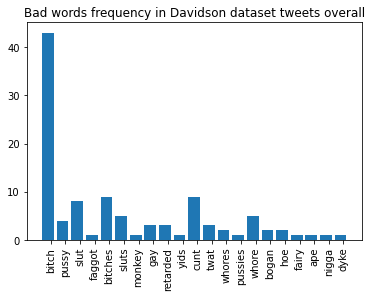

In [40]:
plot_bad_words_histogram(waseem_count_of_words)

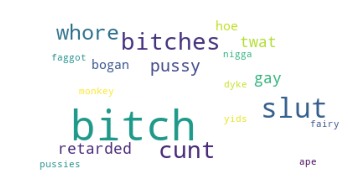

In [41]:
generate_word_cloud(waseem_count_of_words)

We will also split the Waseem dataset based on sexism and racism. Let's start with racism. We will put 0 if racist and 1 if not.

In [42]:
df_was_racism = df_waseem
df_was_racism['class_label'] = df_was_racism['class_label'].map({0:0, 1: 1, 2:1})
df_was_racism

,Unnamed: 0,text,class_label,africoon,alligator bait,anchor baby,anchor babies,ape,bamboo coon,banjo lips,beach nigger,beaner baby,beaner babies,beaner,bitch,bitches,black dago,blaxican,blue gum,bog hopper,bog jumper,bog trotter,bogan,bohunk,boojie,book book,boon,booner,boong,boonga,boonie,bootlip,border bunny,border hopper,border jumper,brass ankle,buckethead,buckra,buckwheat,buddhahead,...,whorientals,wigga,wiggas,wigger,wiggerette,wiggerettes,wiggers,wog,wogs,wops,wopspeak,yank,yankee,yanks,yard ape,yardie,yardies,yellow bone,yellow bones,yellow invader,yellowhammer,yid,yids,yob,yobbo,yobbos,yobs,yokel,yokels,zigabo,zigabos,zio,ziojew,ziojews,zionazi,zip,zipperhead,zippohead,zog,zog lover
2237,2266,"[As, long, as, there, are, people, like, you, ...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2697,2727,"[“, @SueKennedy19, :, #MKR, Please, let, Drask...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
901,929,"[., @ILivUndrUrBed, Anything, but, yourself, ....",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1370,1399,"["", @botticellicream, :, I'm, curvy, ., The, k...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,23,"[I, think, they're, deconstraucted, Pro, . . ....",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,1089,"[RT, @asredasmyhair, :, How, can, feminists, c...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
339,367,"[RT, @LockeTigers3007, :, #mkr, I, want, to, s...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2454,2483,"[RT, @JstnDvs_13, I, can't, stand, any, of, th...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1853,1882,"[RT, @HeyItsReecie, Ok, so, i, hav, a, girl, r...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And now similarly for sexism, 0 if sexist, 1 if not.

In [43]:
df_was_sexism = df_waseem
df_was_sexism['class_label'] = df_was_sexism['class_label'].map({0:1, 1: 0, 2:1})
df_was_sexism

,Unnamed: 0,text,class_label,africoon,alligator bait,anchor baby,anchor babies,ape,bamboo coon,banjo lips,beach nigger,beaner baby,beaner babies,beaner,bitch,bitches,black dago,blaxican,blue gum,bog hopper,bog jumper,bog trotter,bogan,bohunk,boojie,book book,boon,booner,boong,boonga,boonie,bootlip,border bunny,border hopper,border jumper,brass ankle,buckethead,buckra,buckwheat,buddhahead,...,whorientals,wigga,wiggas,wigger,wiggerette,wiggerettes,wiggers,wog,wogs,wops,wopspeak,yank,yankee,yanks,yard ape,yardie,yardies,yellow bone,yellow bones,yellow invader,yellowhammer,yid,yids,yob,yobbo,yobbos,yobs,yokel,yokels,zigabo,zigabos,zio,ziojew,ziojews,zionazi,zip,zipperhead,zippohead,zog,zog lover
2237,2266,"[As, long, as, there, are, people, like, you, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2697,2727,"[“, @SueKennedy19, :, #MKR, Please, let, Drask...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
901,929,"[., @ILivUndrUrBed, Anything, but, yourself, ....",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1370,1399,"["", @botticellicream, :, I'm, curvy, ., The, k...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,23,"[I, think, they're, deconstraucted, Pro, . . ....",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,1089,"[RT, @asredasmyhair, :, How, can, feminists, c...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
339,367,"[RT, @LockeTigers3007, :, #mkr, I, want, to, s...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2454,2483,"[RT, @JstnDvs_13, I, can't, stand, any, of, th...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1853,1882,"[RT, @HeyItsReecie, Ok, so, i, hav, a, girl, r...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Founta Preprocessing for Training

In [44]:
# Preprocess data in other ways + preproces Founta data 
df_founta = preprocessing_method2(df_founta, "text")
df_founta["text"].dropna(inplace=True)
df_founta.to_csv('df_founta.csv', index=False, sep=' ')
df_founta["text"] = df_founta["text"].map(lambda x: custom_tokenize(x)) # needed custom tokenizing due some strange errors with colab
df_founta["class_label"] = df_founta['class_label'].fillna("none")

# Defining which classes we will be dropping when testing
labels_founta = ["class_label", "text"] # crucial to include text here
label_founta = "class_label"
df_founta

,text,class_label
0,"[Beats, by, Dr, Dre, urBeats, Wired, InEar, He...",spam
1,"[Man, it, would, fucking, rule, if, we, had, a...",abusive
2,"[It, is, time, to, draw, close, to, Him, Fathe...",normal
3,"[if, you, notice, me, start, to, act, differen...",normal
4,"[Forget, unfollowers, I, believe, in, growing,...",normal
...,...,...
99991,"[my, fucking, queen, httpstcowaxzzoEWrA]",abusive
99992,"[Osteporosis, treated, with, PEMF, rebuild, bo...",normal
99993,"[why, does, my, phone, screen, keeps, flickrin...",normal
99994,"[bigdata, vs, reality, but, equally, applies, ...",normal


In [45]:
df_founta = df_founta[df_founta.class_label != "spam"]

In [46]:
df_founta['class_label'].loc[(df_founta['class_label'] == "abusive")] = 0
df_founta['class_label'].loc[(df_founta['class_label'] == "hateful")] = 1
df_founta['class_label'].loc[(df_founta['class_label'] == "normal")] = 2
df_founta

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

,text,class_label
1,"[Man, it, would, fucking, rule, if, we, had, a...",0
2,"[It, is, time, to, draw, close, to, Him, Fathe...",2
3,"[if, you, notice, me, start, to, act, differen...",2
4,"[Forget, unfollowers, I, believe, in, growing,...",2
5,"[Hate, Being, sexually, Frustrated, Like, I, w...",0
...,...,...
99991,"[my, fucking, queen, httpstcowaxzzoEWrA]",0
99992,"[Osteporosis, treated, with, PEMF, rebuild, bo...",2
99993,"[why, does, my, phone, screen, keeps, flickrin...",2
99994,"[bigdata, vs, reality, but, equally, applies, ...",2


In [47]:
df_founta = df_founta.sample(frac = 1)
df_founta.head(5)

,text,class_label
84161,"[Manipur, Govt, and, the, Centre, need, to, ta...",2
13711,"[Think, about, how, you, want, things, to, be,...",2
17785,"[I, know, the, people, who, did, work, on, the...",2
58527,"[These, are, the, Anonymous, App, kids, are, u...",2
41200,"[Dont, fucking, look, at, me, unless, you, wan...",0


In [48]:
df_founta.class_label.value_counts()

2    53851
0    27150
1     4965
Name: class_label, dtype: int64

In [49]:
df_founta = df_founta[df_founta['text'].map(len) > 15]

In [50]:
df_founta.class_label.value_counts()

2    37473
0     9643
1     2983
Name: class_label, dtype: int64

In [51]:
add_bad_words(df_founta, "text")
df_founta

,text,class_label,africoon,alligator bait,anchor baby,anchor babies,ape,bamboo coon,banjo lips,beach nigger,beaner baby,beaner babies,beaner,bitch,bitches,black dago,blaxican,blue gum,bog hopper,bog jumper,bog trotter,bogan,bohunk,boojie,book book,boon,booner,boong,boonga,boonie,bootlip,border bunny,border hopper,border jumper,brass ankle,buckethead,buckra,buckwheat,buddhahead,buffie,...,whorientals,wigga,wiggas,wigger,wiggerette,wiggerettes,wiggers,wog,wogs,wops,wopspeak,yank,yankee,yanks,yard ape,yardie,yardies,yellow bone,yellow bones,yellow invader,yellowhammer,yid,yids,yob,yobbo,yobbos,yobs,yokel,yokels,zigabo,zigabos,zio,ziojew,ziojews,zionazi,zip,zipperhead,zippohead,zog,zog lover
84161,"[Manipur, Govt, and, the, Centre, need, to, ta...",2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13711,"[Think, about, how, you, want, things, to, be,...",2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17785,"[I, know, the, people, who, did, work, on, the...",2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21050,"[The, Colosseum, is, so, rich, in, history, Yo...",2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9888,"[If, we, ever, stopped, fuckin, with, eachothe...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53672,"[A, BlackPanther, perspective, on, they, syste...",2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24788,"[Fucking, Ets, disease, MetsJets, and, for, so...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73533,"[I, Just, heard, a, news, that, an, idiot, is,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99078,"[She, must, of, made, a, ugly, bitch, mad, af,...",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
df_founta.class_label.value_counts()

2    37473
0     9643
1     2983
Name: class_label, dtype: int64

In [53]:
founta_count_of_words = get_bad_words(df_founta, "text")
print(founta_count_of_words[:50])

KeyboardInterrupt: ignored

In [54]:
df_founta.class_label.value_counts()

2    37473
0     9643
1     2983
Name: class_label, dtype: int64

In [55]:
plot_bad_words_histogram(founta_count_of_words)

NameError: ignored

In [ ]:
generate_word_cloud(founta_count_of_words)

In [56]:
df_was_abusive = df_founta
df_was_abusive['class_label'] = df_was_abusive['class_label'].map({0:0, 1: 1, 2:1})
df_was_abusive

,text,class_label,africoon,alligator bait,anchor baby,anchor babies,ape,bamboo coon,banjo lips,beach nigger,beaner baby,beaner babies,beaner,bitch,bitches,black dago,blaxican,blue gum,bog hopper,bog jumper,bog trotter,bogan,bohunk,boojie,book book,boon,booner,boong,boonga,boonie,bootlip,border bunny,border hopper,border jumper,brass ankle,buckethead,buckra,buckwheat,buddhahead,buffie,...,whorientals,wigga,wiggas,wigger,wiggerette,wiggerettes,wiggers,wog,wogs,wops,wopspeak,yank,yankee,yanks,yard ape,yardie,yardies,yellow bone,yellow bones,yellow invader,yellowhammer,yid,yids,yob,yobbo,yobbos,yobs,yokel,yokels,zigabo,zigabos,zio,ziojew,ziojews,zionazi,zip,zipperhead,zippohead,zog,zog lover
84161,"[Manipur, Govt, and, the, Centre, need, to, ta...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13711,"[Think, about, how, you, want, things, to, be,...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17785,"[I, know, the, people, who, did, work, on, the...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21050,"[The, Colosseum, is, so, rich, in, history, Yo...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9888,"[If, we, ever, stopped, fuckin, with, eachothe...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53672,"[A, BlackPanther, perspective, on, they, syste...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24788,"[Fucking, Ets, disease, MetsJets, and, for, so...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73533,"[I, Just, heard, a, news, that, an, idiot, is,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99078,"[She, must, of, made, a, ugly, bitch, mad, af,...",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
df_was_abusive.class_label.value_counts()

1    40456
0     9643
Name: class_label, dtype: int64

In [58]:
df_was_hateful = df_founta
df_was_hateful['class_label'] = df_was_hateful['class_label'].map({0:1, 1: 0, 2:1})
df_was_hateful

,text,class_label,africoon,alligator bait,anchor baby,anchor babies,ape,bamboo coon,banjo lips,beach nigger,beaner baby,beaner babies,beaner,bitch,bitches,black dago,blaxican,blue gum,bog hopper,bog jumper,bog trotter,bogan,bohunk,boojie,book book,boon,booner,boong,boonga,boonie,bootlip,border bunny,border hopper,border jumper,brass ankle,buckethead,buckra,buckwheat,buddhahead,buffie,...,whorientals,wigga,wiggas,wigger,wiggerette,wiggerettes,wiggers,wog,wogs,wops,wopspeak,yank,yankee,yanks,yard ape,yardie,yardies,yellow bone,yellow bones,yellow invader,yellowhammer,yid,yids,yob,yobbo,yobbos,yobs,yokel,yokels,zigabo,zigabos,zio,ziojew,ziojews,zionazi,zip,zipperhead,zippohead,zog,zog lover
84161,"[Manipur, Govt, and, the, Centre, need, to, ta...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13711,"[Think, about, how, you, want, things, to, be,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17785,"[I, know, the, people, who, did, work, on, the...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21050,"[The, Colosseum, is, so, rich, in, history, Yo...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9888,"[If, we, ever, stopped, fuckin, with, eachothe...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53672,"[A, BlackPanther, perspective, on, they, syste...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24788,"[Fucking, Ets, disease, MetsJets, and, for, so...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73533,"[I, Just, heard, a, news, that, an, idiot, is,...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99078,"[She, must, of, made, a, ugly, bitch, mad, af,...",1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
df_was_hateful.class_label.value_counts()

0    40456
1     9643
Name: class_label, dtype: int64

In [60]:
df_founta.class_label.value_counts()

0    40456
1     9643
Name: class_label, dtype: int64

#### Founta Minimal Preprocessing

In [61]:
df_founta2 = preprocessing_method_minimal(df_founta, "text")
df_founta2["text"].dropna(inplace=True)
df_founta2.to_csv('df_was.csv', index=False, sep=' ')
df_founta2["text"] = df_founta2["text"].map(lambda x: custom_tokenize(x)) # needed custom tokenizing due some strange errors with colab
df_founta2["class_label"] = df_founta2['class_label'].fillna("none")

# Defining which classes we will be dropping when testing
labels_founta2 = ["class_label", "text"] # crucial to include text here
label_founta2 = "class_label"
df_founta2

,text,class_label,africoon,alligator bait,anchor baby,anchor babies,ape,bamboo coon,banjo lips,beach nigger,beaner baby,beaner babies,beaner,bitch,bitches,black dago,blaxican,blue gum,bog hopper,bog jumper,bog trotter,bogan,bohunk,boojie,book book,boon,booner,boong,boonga,boonie,bootlip,border bunny,border hopper,border jumper,brass ankle,buckethead,buckra,buckwheat,buddhahead,buffie,...,whorientals,wigga,wiggas,wigger,wiggerette,wiggerettes,wiggers,wog,wogs,wops,wopspeak,yank,yankee,yanks,yard ape,yardie,yardies,yellow bone,yellow bones,yellow invader,yellowhammer,yid,yids,yob,yobbo,yobbos,yobs,yokel,yokels,zigabo,zigabos,zio,ziojew,ziojews,zionazi,zip,zipperhead,zippohead,zog,zog lover
84161,"[[, ', Manipur, ', ,, ', Govt, ', ,, ', and, '...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13711,"[[, ', Think, ', ,, ', about, ', ,, ', how, ',...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17785,"[[, ', I, ', ,, ', know, ', ,, ', the, ', ,, '...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21050,"[[, ', The, ', ,, ', Colosseum, ', ,, ', is, '...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9888,"[[, ', If, ', ,, ', we, ', ,, ', ever, ', ,, '...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53672,"[[, ', A, ', ,, ', BlackPanther, ', ,, ', pers...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24788,"[[, ', Fucking, ', ,, ', Ets, ', ,, ', disease...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73533,"[[, ', I, ', ,, ', Just, ', ,, ', heard, ', ,,...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99078,"[[, ', She, ', ,, ', must, ', ,, ', of, ', ,, ...",1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
df_founta2 = df_founta2[df_founta2.class_label != "spam"]

In [63]:
df_founta2['class_label'].loc[(df_founta2['class_label'] == "abusive")] = 0
df_founta2['class_label'].loc[(df_founta2['class_label'] == "hateful")] = 1
df_founta2['class_label'].loc[(df_founta2['class_label'] == "normal")] = 2
df_founta2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,text,class_label,africoon,alligator bait,anchor baby,anchor babies,ape,bamboo coon,banjo lips,beach nigger,beaner baby,beaner babies,beaner,bitch,bitches,black dago,blaxican,blue gum,bog hopper,bog jumper,bog trotter,bogan,bohunk,boojie,book book,boon,booner,boong,boonga,boonie,bootlip,border bunny,border hopper,border jumper,brass ankle,buckethead,buckra,buckwheat,buddhahead,buffie,...,whorientals,wigga,wiggas,wigger,wiggerette,wiggerettes,wiggers,wog,wogs,wops,wopspeak,yank,yankee,yanks,yard ape,yardie,yardies,yellow bone,yellow bones,yellow invader,yellowhammer,yid,yids,yob,yobbo,yobbos,yobs,yokel,yokels,zigabo,zigabos,zio,ziojew,ziojews,zionazi,zip,zipperhead,zippohead,zog,zog lover
84161,"[[, ', Manipur, ', ,, ', Govt, ', ,, ', and, '...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13711,"[[, ', Think, ', ,, ', about, ', ,, ', how, ',...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17785,"[[, ', I, ', ,, ', know, ', ,, ', the, ', ,, '...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21050,"[[, ', The, ', ,, ', Colosseum, ', ,, ', is, '...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9888,"[[, ', If, ', ,, ', we, ', ,, ', ever, ', ,, '...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53672,"[[, ', A, ', ,, ', BlackPanther, ', ,, ', pers...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24788,"[[, ', Fucking, ', ,, ', Ets, ', ,, ', disease...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73533,"[[, ', I, ', ,, ', Just, ', ,, ', heard, ', ,,...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99078,"[[, ', She, ', ,, ', must, ', ,, ', of, ', ,, ...",1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
df_founta2 = df_founta2.sample(frac = 1)
df_founta2.head(5)

,text,class_label,africoon,alligator bait,anchor baby,anchor babies,ape,bamboo coon,banjo lips,beach nigger,beaner baby,beaner babies,beaner,bitch,bitches,black dago,blaxican,blue gum,bog hopper,bog jumper,bog trotter,bogan,bohunk,boojie,book book,boon,booner,boong,boonga,boonie,bootlip,border bunny,border hopper,border jumper,brass ankle,buckethead,buckra,buckwheat,buddhahead,buffie,...,whorientals,wigga,wiggas,wigger,wiggerette,wiggerettes,wiggers,wog,wogs,wops,wopspeak,yank,yankee,yanks,yard ape,yardie,yardies,yellow bone,yellow bones,yellow invader,yellowhammer,yid,yids,yob,yobbo,yobbos,yobs,yokel,yokels,zigabo,zigabos,zio,ziojew,ziojews,zionazi,zip,zipperhead,zippohead,zog,zog lover
73193,"[[, ', Warner, ', ,, ', Bros, ', ,, ', might, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
72754,"[[, ', Just, ', ,, ', like, ', ,, ', Caroline,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71603,"[[, ', TWO, ', ,, ', THINGS, ', ,, ', THAT, ',...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20920,"[[, ', Mark, ', ,, ', Cuban, ', ,, ', and, ', ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35176,"[[, ', Symbols, ', ,, ', are, ', ,, ', given, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
df_founta2 = df_founta2[df_founta2['text'].map(len) > 15]

In [66]:
add_bad_words(df_founta2, "text")
df_founta2

,text,class_label,africoon,alligator bait,anchor baby,anchor babies,ape,bamboo coon,banjo lips,beach nigger,beaner baby,beaner babies,beaner,bitch,bitches,black dago,blaxican,blue gum,bog hopper,bog jumper,bog trotter,bogan,bohunk,boojie,book book,boon,booner,boong,boonga,boonie,bootlip,border bunny,border hopper,border jumper,brass ankle,buckethead,buckra,buckwheat,buddhahead,buffie,...,whorientals,wigga,wiggas,wigger,wiggerette,wiggerettes,wiggers,wog,wogs,wops,wopspeak,yank,yankee,yanks,yard ape,yardie,yardies,yellow bone,yellow bones,yellow invader,yellowhammer,yid,yids,yob,yobbo,yobbos,yobs,yokel,yokels,zigabo,zigabos,zio,ziojew,ziojews,zionazi,zip,zipperhead,zippohead,zog,zog lover
73193,"[[, ', Warner, ', ,, ', Bros, ', ,, ', might, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
72754,"[[, ', Just, ', ,, ', like, ', ,, ', Caroline,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71603,"[[, ', TWO, ', ,, ', THINGS, ', ,, ', THAT, ',...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20920,"[[, ', Mark, ', ,, ', Cuban, ', ,, ', and, ', ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35176,"[[, ', Symbols, ', ,, ', are, ', ,, ', given, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,"[[, ', I, ', ,, ', always, ', ,, ', forget, ',...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43943,"[[, ', And, ', ,, ', youre, ', ,, ', being, ',...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3471,"[[, ', Russia, ', ,, ', PM, ', ,, ', Medvedev,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44487,"[[, ', Literally, ', ,, ', everything, ', ,, '...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
founta_count_of_words2 = get_bad_words(df_founta2, "text")

In [ ]:
print(founta_count_of_words2[:50])

In [ ]:
plot_bad_words_histogram(founta_count_of_words2)

In [ ]:
generate_word_cloud(founta_count_of_words2)

In [67]:
df_was_abusive2 = df_founta2
df_was_abusive2['class_label'] = df_was_abusive2['class_label'].map({0:0, 1: 1, 2:1})
df_was_abusive2

,text,class_label,africoon,alligator bait,anchor baby,anchor babies,ape,bamboo coon,banjo lips,beach nigger,beaner baby,beaner babies,beaner,bitch,bitches,black dago,blaxican,blue gum,bog hopper,bog jumper,bog trotter,bogan,bohunk,boojie,book book,boon,booner,boong,boonga,boonie,bootlip,border bunny,border hopper,border jumper,brass ankle,buckethead,buckra,buckwheat,buddhahead,buffie,...,whorientals,wigga,wiggas,wigger,wiggerette,wiggerettes,wiggers,wog,wogs,wops,wopspeak,yank,yankee,yanks,yard ape,yardie,yardies,yellow bone,yellow bones,yellow invader,yellowhammer,yid,yids,yob,yobbo,yobbos,yobs,yokel,yokels,zigabo,zigabos,zio,ziojew,ziojews,zionazi,zip,zipperhead,zippohead,zog,zog lover
73193,"[[, ', Warner, ', ,, ', Bros, ', ,, ', might, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
72754,"[[, ', Just, ', ,, ', like, ', ,, ', Caroline,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71603,"[[, ', TWO, ', ,, ', THINGS, ', ,, ', THAT, ',...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20920,"[[, ', Mark, ', ,, ', Cuban, ', ,, ', and, ', ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35176,"[[, ', Symbols, ', ,, ', are, ', ,, ', given, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,"[[, ', I, ', ,, ', always, ', ,, ', forget, ',...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43943,"[[, ', And, ', ,, ', youre, ', ,, ', being, ',...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3471,"[[, ', Russia, ', ,, ', PM, ', ,, ', Medvedev,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44487,"[[, ', Literally, ', ,, ', everything, ', ,, '...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
df_was_hateful2 = df_founta2
df_was_hateful2['class_label'] = df_was_hateful2['class_label'].map({0:1, 1: 0, 2:1})
df_was_hateful2

,text,class_label,africoon,alligator bait,anchor baby,anchor babies,ape,bamboo coon,banjo lips,beach nigger,beaner baby,beaner babies,beaner,bitch,bitches,black dago,blaxican,blue gum,bog hopper,bog jumper,bog trotter,bogan,bohunk,boojie,book book,boon,booner,boong,boonga,boonie,bootlip,border bunny,border hopper,border jumper,brass ankle,buckethead,buckra,buckwheat,buddhahead,buffie,...,whorientals,wigga,wiggas,wigger,wiggerette,wiggerettes,wiggers,wog,wogs,wops,wopspeak,yank,yankee,yanks,yard ape,yardie,yardies,yellow bone,yellow bones,yellow invader,yellowhammer,yid,yids,yob,yobbo,yobbos,yobs,yokel,yokels,zigabo,zigabos,zio,ziojew,ziojews,zionazi,zip,zipperhead,zippohead,zog,zog lover
73193,"[[, ', Warner, ', ,, ', Bros, ', ,, ', might, ...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
72754,"[[, ', Just, ', ,, ', like, ', ,, ', Caroline,...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71603,"[[, ', TWO, ', ,, ', THINGS, ', ,, ', THAT, ',...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20920,"[[, ', Mark, ', ,, ', Cuban, ', ,, ', and, ', ...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35176,"[[, ', Symbols, ', ,, ', are, ', ,, ', given, ...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,"[[, ', I, ', ,, ', always, ', ,, ', forget, ',...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43943,"[[, ', And, ', ,, ', youre, ', ,, ', being, ',...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3471,"[[, ', Russia, ', ,, ', PM, ', ,, ', Medvedev,...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44487,"[[, ', Literally, ', ,, ', everything, ', ,, '...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# TODO (Zach): after adding Hate base as bag of words, preprocess the data and also run the models on it later 

#Models
In this section, we will initialize model functions that we will later use to see which Machine Learning Model performs best for the task of hate speech detection. 
Note that for all the models, "output" input specifies if we want to output metrics or predictions and test data. 

In [69]:
# TODO (all): right now all the models are running for all labels simultaneously
# for example it is assigning sexism, racism, none at the same time
# in the paper, they do it separetly. Hence we should keep what we have but
# we should also have the separation 
# Bottom line: DO NOT DELETE THE CODE FOR THEM at once but rather also
# add the code for all 2 separately for each dataset
# Remember, this step will include also adding the code to the later section, make
# sure it is also added there.

## Decision Tree Classifier

In this section we define Decision Tree Classifier. We used max_depth to be 10 and min_samples_leaf to be 5. 

In [70]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree_classifier(dataset, labels, label, output):
  X_train, X_test, y_train, y_test = train_test_split(dataset.drop(labels, axis = 1), dataset[label].astype(int), test_size = 0.3)
  clf = DecisionTreeClassifier(random_state = 100, max_depth = 10, min_samples_leaf = 5)
  clf.fit(X_train, y_train)
  decision_tree_preds = clf.predict(X_test)
  y_test_decision = y_test
  if (output == 'metrics'):
    return precision_recall_fscore_support(y_test, decision_tree_preds)
  else:
    return decision_tree_preds, y_test

## Adabooost Classifier

Here, we trained yet another classifier– Adaboost. 

In [71]:
from sklearn.ensemble import AdaBoostClassifier
def adaboost_classifier(df, labels, label, output):
  X_train, X_test, y_train, y_test = train_test_split(df.drop(labels, axis = 1), df[label].astype(int), test_size = 0.3)
  clf = AdaBoostClassifier()
  clf.fit(X_train, y_train)
  adaboost_preds = clf.predict(X_test)
  y_test_adaboost = y_test
  if (output == 'metrics'):
    return precision_recall_fscore_support(y_test, adaboost_preds)
  else:
    return adaboost_preds, y_test

## Logistic Regression

Third model we used is the same model as they used in the study— logisitic regression. 

In [72]:
from sklearn.linear_model import LogisticRegression

def logisitic_regression_classifier(df, labels, label, output):
  X_train, X_test, y_train, y_test = train_test_split(df.drop(labels, axis = 1), df[label].astype(int), test_size = 0.3)

  clf = LogisticRegression()
  clf.fit(X_train, y_train)

  logistic_preds = clf.predict(X_test)
  y_test_logisitic = y_test
  if (output == 'metrics'):
    return precision_recall_fscore_support(y_test, logistic_preds)
  else:
    return logistic_preds, y_test

## Linear Regression
Here we will explore linear regression. We will use MSE, R2 score, and RMSE to assess our results because we cannot use precision, accuracy, and recall for Linear Regression.

In [73]:
from sklearn.linear_model import LinearRegression

def linear_regression_classifier(df, labels, label, output):
  X_train, X_test, y_train, y_test = train_test_split(df.drop(labels, axis = 1), df[label].astype(int), test_size = 0.3)

  clf = LinearRegression()
  clf.fit(X_train, y_train)

  lin_preds = clf.predict(X_test)
  y_test_lin = y_test

  if (output == 'metrics'):
    return [mean_squared_error(y_test_lin, lin_preds), r2_score(y_test_lin, lin_preds), 
          mean_squared_error(y_test_lin, lin_preds, squared=False)] # in order MSE, R2, RMSE
  else:
    return lin_preds, y_test

## Random Forest
In this part we will create **Random Forest** Classifier with usage of **gini** index. 

In [74]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier_gini(df, labels, label, output):
  X_train, X_test, y_train, y_test = train_test_split(df.drop(labels, axis = 1), df[label].astype(int), test_size = 0.3)

  clf = RandomForestClassifier()
  clf.fit(X_train, y_train)

  random_forest_preds = clf.predict(X_test)
  y_test_rf = y_test
  if (output == 'metrics'):
    return precision_recall_fscore_support(y_test, random_forest_preds)
  else:
    return random_forest_preds, y_test

And now with usage of **entropy**. 

In [75]:
def random_forest_classifier_entropy(df, labels, label, output):
  X_train, X_test, y_train, y_test = train_test_split(df.drop(labels, axis = 1), df[label].astype(int), test_size = 0.3)

  clf = RandomForestClassifier(criterion="entropy")
  clf.fit(X_train, y_train)

  random_forest_preds = clf.predict(X_test)
  y_test_rf = y_test
  if (output == 'metrics'):
    return precision_recall_fscore_support(y_test, random_forest_preds)
  else:
    return random_forest_preds, y_test

## K-means

Now we will use k-means for this problem. 

In [76]:
from sklearn.cluster import KMeans
def k_means_cluster(df, labels, label, k, output):
  X_train, X_test, y_train, y_test = train_test_split(df.drop(labels, axis = 1), df[label].astype(int), test_size = 0.3)
  clf = KMeans(n_clusters = k)
  clf.fit(X_train, y_train)
  k_means_preds = clf.predict(X_test)
  y_test_k_means = y_test
  if (output == 'metrics'):
    return precision_recall_fscore_support(y_test, k_means_preds)
  else:
    return k_means_preds, t_test

## Ensemble models
In this section, we will explore various ensemble models. 

In [77]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
def ensemble_1(df, labels, label, output):
  X_train, X_test, y_train, y_test = train_test_split(df.drop(labels, axis = 1), df[label].astype(int), test_size = 0.3)
  layer_one_estimators = [
                        ('rf_1', RandomForestClassifier(n_estimators=10, random_state=42)),
                        ('knn_1', KNeighborsClassifier(n_neighbors=5))             
                       ]
  layer_two_estimators = [
                        ('dt_2', DecisionTreeClassifier()),
                        ('rf_2', RandomForestClassifier(n_estimators=50, random_state=42)),
                       ]
  layer_two = StackingClassifier(estimators=layer_two_estimators, final_estimator=LogisticRegression())
  clf = StackingClassifier(estimators=layer_one_estimators, final_estimator=layer_two)
  clf.fit(X_train, y_train)
  ensemble1_preds = clf.predict(X_test)
  if (output == 'metrics'):
    return precision_recall_fscore_support(y_test, ensemble1_preds)
  else:
    return ensemble1_preds, y_test

Let's try another ensemble model.

In [78]:
from sklearn.ensemble import VotingClassifier
def ensemble_2(df, labels, label, output):
  X_train, X_test, y_train, y_test = train_test_split(df.drop(labels, axis = 1), df[label].astype(int), test_size = 0.3)
  layer_one_estimators = [
                          ('rf_1', RandomForestClassifier(n_estimators=25, random_state=42)),
                          ('a_1', AdaBoostClassifier())
  ]
  layer_two_estimators = [
                          ('a_2', AdaBoostClassifier()),
                          ('km_2', KNeighborsClassifier(n_neighbors=5))
  ]
  layer_two = VotingClassifier(estimators=layer_two_estimators, voting='soft') # voting soft will use argmax
  clf = StackingClassifier(estimators=layer_one_estimators, final_estimator=layer_two)
  clf.fit(X_train, y_train)
  ensemble2_preds = clf.predict(X_test)
  if (output == 'metrics'):
    return precision_recall_fscore_support(y_test, ensemble2_preds)
  else:
    return ensemble2_preds, y_test

And let's try third ensemble model. 

In [79]:
from sklearn.ensemble import BaggingClassifier
def ensemble_3(df, labels, label, output):
  X_train, X_test, y_train, y_test = train_test_split(df.drop(labels, axis = 1), df[label].astype(int), test_size = 0.3)
  layer_one_estimators = [
                          ('bg_1', BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_estimators=25)),
                          ('a_1', DecisionTreeClassifier())
  ]
  layer_two_estimators = [
                          ('a_2', AdaBoostClassifier()),
                          ('km_2', KNeighborsClassifier(n_neighbors=5))
  ]
  layer_two = VotingClassifier(estimators=layer_two_estimators, voting='soft') # voting soft will use argmax
  clf = StackingClassifier(estimators=layer_one_estimators, final_estimator=layer_two)
  clf.fit(X_train, y_train)
  ensemble2_preds = clf.predict(X_test)
  if (output == 'metrics'):
    return precision_recall_fscore_support(y_test, ensemble2_preds)
  else:
    return ensemble2_preds, y_test

# Running the models on the data
In this section, we will use functions defined above to run them on the preprocessed data. 

First, let's create dictionaries for storing the accuracies.

In [80]:
davidson_overall_dict = {}
davidson_ol_dict = {}
davidson_hs_dict = {}

waseem_overall_dict = {}
waseem_sexism_dict = {}
waseem_racism_dict = {}

founta_overall_dict = {}
founta_abusive_dict = {}
founta_hateful_dict = {}

founta2_overall_dict = {}
founta2_abusive_dict = {}
founta2_hateful_dict = {}
founta2_normal_dict = {}

## Decision Tree

#### Decision Tree: Davidson

First, we will run our data on the **Decision Tree Classifier**. We start with **Davidson data**. 

In [81]:
decision_tree_metrics_davidson = decision_tree_classifier(df_davidson, labels_davidson, label_davidson, 'metrics')
davidson_overall_dict["Decision Tree"] = decision_tree_metrics_davidson
decision_tree_metrics_davidson

(array([0.94570197, 0.46153846]),
 array([0.9990037 , 0.01466993]),
 array([0.97162237, 0.02843602]),
 array([7026,  409]))

Now let's run it on just **offensive language** label for **Davidson** dataset.

In [82]:
decision_tree_metrics_davidson_ol = decision_tree_classifier(df_dav_ol, labels_davidson, label_davidson, 'metrics')
davidson_ol_dict["Decision Tree"] = decision_tree_metrics_davidson_ol
decision_tree_metrics_davidson_ol

(array([0.94160486, 0.55      ]),
 array([0.99871263, 0.02477477]),
 array([0.96931834, 0.04741379]),
 array([6991,  444]))

... and for **hate speech** for the **Davidson** dataset. 

In [83]:
decision_tree_metrics_davidson_hs = decision_tree_classifier(df_dav_hs, labels_davidson, label_davidson, 'metrics')
davidson_hs_dict["Decision Tree"] = decision_tree_metrics_davidson_hs
decision_tree_metrics_davidson_hs

(array([0.93847814, 0.47826087]),
 array([0.99827784, 0.0235546 ]),
 array([0.9674548 , 0.04489796]),
 array([6968,  467]))

#### Decision Tree: Waseem

Then we run it on the **Waseem data.** 

In [84]:
decision_tree_metrics_waseem = decision_tree_classifier(df_waseem, labels_waseem, label_waseem, 'metrics')
waseem_overall_dict["Decision Tree"] = decision_tree_metrics_waseem
decision_tree_metrics_waseem

(array([0.99878049, 1.        ]),
 array([1.  , 0.75]),
 array([0.99938987, 0.85714286]),
 array([819,   4]))

Now let's just do predictions for **sexism** from **Waseem** dataset. 

In [85]:
decision_tree_metrics_waseem_sexism = decision_tree_classifier(df_was_sexism, labels_waseem, label_waseem, 'metrics')
waseem_sexism_dict["Decision Tree"] = decision_tree_metrics_waseem_sexism
decision_tree_metrics_waseem_sexism

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([817,   6]))

... and for **racism**. 

In [86]:
decision_tree_metrics_waseem_racism = decision_tree_classifier(df_was_racism, labels_waseem, label_waseem, 'metrics')
waseem_racism_dict["Decision Tree"] = decision_tree_metrics_waseem_racism
decision_tree_metrics_waseem_racism

(array([1.  , 0.75]),
 array([0.99878049, 1.        ]),
 array([0.99938987, 0.85714286]),
 array([820,   3]))

#### Decision Tree: Founta

In [87]:
decision_tree_metrics_founta = decision_tree_classifier(df_founta, labels_founta, label_founta, 'metrics')
founta_overall_dict["Decision Tree"] = decision_tree_metrics_founta
decision_tree_metrics_founta

(array([0.8252679 , 0.85488127]),
 array([0.99547176, 0.11234397]),
 array([0.90241445, 0.19859025]),
 array([12146,  2884]))

In [88]:
decision_tree_metrics_founta_abusive = decision_tree_classifier(df_was_abusive, labels_founta, label_founta, 'metrics')
founta_abusive_dict["Decision Tree"] = decision_tree_metrics_founta_abusive
decision_tree_metrics_founta_abusive

(array([0.82462967, 0.86089239]),
 array([0.99563175, 0.11322057]),
 array([0.90209842, 0.20012203]),
 array([12133,  2897]))

In [89]:
decision_tree_metrics_founta_hateful = decision_tree_classifier(df_was_hateful, labels_founta, label_founta, 'metrics')
founta_hateful_dict["Decision Tree"] = decision_tree_metrics_founta_hateful
decision_tree_metrics_founta_hateful

(array([0.8215309 , 0.87634409]),
 array([0.99619457, 0.11080897]),
 array([0.9004711, 0.1967411]),
 array([12088,  2942]))

#### Decision Tree: Founta Control

In [90]:
decision_tree_metrics_founta2 = decision_tree_classifier(df_founta2, labels_founta2, label_founta2, 'metrics')
founta2_overall_dict["Decision Tree"] = decision_tree_metrics_founta2
decision_tree_metrics_founta2

(array([0.81971831, 0.82166951]),
 array([0.10006878, 0.99472034]),
 array([0.17836347, 0.89995149]),
 array([ 2908, 12122]))

In [91]:
decision_tree_metrics_founta_abusive2 = decision_tree_classifier(df_was_abusive2, labels_founta2, label_founta2, 'metrics')
founta2_abusive_dict["Decision Tree"] = decision_tree_metrics_founta_abusive2
decision_tree_metrics_founta_abusive2

(array([0.87692308, 0.82554645]),
 array([0.11809392, 0.99604417]),
 array([0.20815581, 0.90281616]),
 array([ 2896, 12134]))

In [92]:
decision_tree_metrics_founta_hateful2 = decision_tree_classifier(df_was_hateful2, labels_founta2, label_founta2, 'metrics')
founta2_hateful_dict["Decision Tree"] = decision_tree_metrics_founta_hateful2
decision_tree_metrics_founta_hateful2

(array([0.87301587, 0.82152607]),
 array([0.11205433, 0.99602813]),
 array([0.19861571, 0.90040019]),
 array([ 2945, 12085]))

## Adaboost

#### Adaboost: Davidson

Next, we will use **Adaboost**. We will yet again start with Davidson dataset. 

In [93]:
adaboost_metrics_davidson = adaboost_classifier(df_davidson, labels_davidson, label_davidson, 'metrics')
davidson_overall_dict["Adaboost"] = adaboost_metrics_davidson
adaboost_metrics_davidson

(array([0.94090539, 0.43859649]),
 array([0.99541153, 0.05422993]),
 array([0.9673913, 0.0965251]),
 array([6974,  461]))

Now just for **offensive language** from **Davidson**. 

In [94]:
adaboost_metrics_davidson_ol = adaboost_classifier(df_dav_ol, labels_davidson, label_davidson, 'metrics')
davidson_ol_dict["Adaboost"] = adaboost_metrics_davidson_ol
adaboost_metrics_davidson_ol

(array([0.94485842, 0.38888889]),
 array([0.99529042, 0.04906542]),
 array([0.96941896, 0.08713693]),
 array([7007,  428]))

... and just **hate speech** from **Davidson**.

In [95]:
adaboost_metrics_davidson_hs = adaboost_classifier(df_dav_hs, labels_davidson, label_davidson, 'metrics')
davidson_hs_dict["Adaboost"] = adaboost_metrics_davidson_hs
adaboost_metrics_davidson_hs

(array([0.94674075, 0.42857143]),
 array([0.9954403 , 0.05755396]),
 array([0.97047996, 0.10147992]),
 array([7018,  417]))

#### Adaboost: Waseem

Next, **Waseem**.

In [96]:
adaboost_metrics_waseem = adaboost_classifier(df_waseem, labels_waseem, label_waseem, 'metrics')
waseem_overall_dict["Adaboost"] = adaboost_metrics_waseem
adaboost_metrics_waseem

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([818,   5]))

Now let's just look at **sexism** from **Waseem**.

In [97]:
adaboost_metrics_waseem_sexism = adaboost_classifier(df_was_sexism, labels_waseem, label_waseem, 'metrics')
waseem_sexism_dict["Adaboost"] = adaboost_metrics_waseem_sexism
adaboost_metrics_waseem_sexism

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([822,   1]))

and now just **racism** from **Waseem**.

In [98]:
adaboost_metrics_waseem_racism = adaboost_classifier(df_was_racism, labels_waseem, label_waseem, 'metrics')
waseem_racism_dict["Adaboost"] = adaboost_metrics_waseem_racism
adaboost_metrics_waseem_racism

(array([1.        , 0.66666667]),
 array([0.99878197, 1.        ]),
 array([0.99939062, 0.8       ]),
 array([821,   2]))

#### Adaboost Founta

In [99]:
adaboost_metrics_founta = adaboost_classifier(df_founta, labels_founta, label_founta, 'metrics')
founta_overall_dict["Adaboost"] = adaboost_metrics_founta
adaboost_metrics_founta

(array([0.82545753, 0.84715026]),
 array([0.99514283, 0.11342352]),
 array([0.90239259, 0.20006118]),
 array([12147,  2883]))

In [100]:
adaboost_metrics_founta_abusive = adaboost_classifier(df_was_abusive, labels_founta, label_founta, 'metrics')
founta_abusive_dict["Adaboost"] = adaboost_metrics_founta_abusive
adaboost_metrics_founta_abusive

(array([0.8265892, 0.8625   ]),
 array([0.99547251, 0.11970854]),
 array([0.90320412, 0.21023766]),
 array([12148,  2882]))

In [101]:
adaboost_metrics_founta_hateful = adaboost_classifier(df_was_hateful, labels_founta, label_founta, 'metrics')
founta_hateful_dict["Adaboost"] = adaboost_metrics_founta_hateful
adaboost_metrics_founta_hateful

(array([0.82769924, 0.83204134]),
 array([0.99466557, 0.11318102]),
 array([0.90353362, 0.19925743]),
 array([12185,  2845]))

#### Adaboost: Founta Control

In [102]:
adaboost_metrics_founta2 = adaboost_classifier(df_founta2, labels_founta2, label_founta2, 'metrics')
founta2_overall_dict["Adaboost"] = adaboost_metrics_founta2
adaboost_metrics_founta2

(array([0.83418367, 0.83112447]),
 array([0.11682744, 0.99468563]),
 array([0.20495143, 0.90557892]),
 array([ 2799, 12231]))

In [103]:
adaboost_metrics_founta_abusive2 = adaboost_classifier(df_was_abusive2, labels_founta2, label_founta2, 'metrics')
founta2_abusive_dict["Adaboost"] = adaboost_metrics_founta_abusive2
adaboost_metrics_founta_abusive2

(array([0.80973451, 0.82981205]),
 array([0.12855638, 0.99294098]),
 array([0.22188542, 0.90407683]),
 array([ 2847, 12183]))

In [104]:
adaboost_metrics_founta_hateful2 = adaboost_classifier(df_was_hateful2, labels_founta2, label_founta2, 'metrics')
founta2_hateful_dict["Adaboost"] = adaboost_metrics_founta_hateful2
adaboost_metrics_founta_hateful2

(array([0.83673469, 0.82921164]),
 array([0.11598303, 0.99475496]),
 array([0.20372671, 0.90447094]),
 array([ 2828, 12202]))

## Logistic Regression

#### Logistic Regression: Davidson

Next, we will use **Logistic Regression** similarly to to what they did in the paper. We will start with **Davidson** data. 

In [105]:
log_reg_metrics_davidson = logisitic_regression_classifier(df_davidson, labels_davidson, label_davidson, 'metrics')
davidson_overall_dict["Logistic Regression"] = log_reg_metrics_davidson
log_reg_metrics_davidson

(array([0.94547908, 0.16      ]),
 array([0.99701153, 0.00980392]),
 array([0.97056175, 0.01847575]),
 array([7027,  408]))

Now just on **offensive language** in **Davidson**.

In [106]:
log_reg_metrics_davidson_ol = logisitic_regression_classifier(df_dav_ol, labels_davidson, label_davidson, 'metrics')
davidson_ol_dict["Logistic Regression"] = log_reg_metrics_davidson_ol
log_reg_metrics_davidson_ol

(array([0.9451203 , 0.45945946]),
 array([0.99714775, 0.04018913]),
 array([0.9704372 , 0.07391304]),
 array([7012,  423]))

And now just **hate speech** for **Davidson**. 

In [107]:
log_reg_metrics_davidson_hs = logisitic_regression_classifier(df_dav_hs, labels_davidson, label_davidson, 'metrics')
davidson_hs_dict["Logistic Regression"] = log_reg_metrics_davidson_hs
log_reg_metrics_davidson_hs

(array([0.94502971, 0.4516129 ]),
 array([0.99757628, 0.03325416]),
 array([0.97059232, 0.0619469 ]),
 array([7014,  421]))

#### Logistic Regression: Waseem

And **Waseem**:

In [108]:
log_reg_metrics_waseem = logisitic_regression_classifier(df_waseem, labels_waseem, label_waseem, 'metrics')
waseem_overall_dict["Logistic Regression"] = log_reg_metrics_waseem
log_reg_metrics_waseem

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([820,   3]))

Now **sexism** for **Waseem**.

In [109]:
log_reg_metrics_waseem_sexism = logisitic_regression_classifier(df_was_sexism, labels_waseem, label_waseem, 'metrics')
waseem_sexism_dict["Logistic Regression"] = log_reg_metrics_waseem_sexism
log_reg_metrics_waseem_sexism

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([816,   7]))

Now **racism** on **Waseem**. 

In [110]:
log_reg_metrics_waseem_racism = logisitic_regression_classifier(df_was_racism, labels_waseem, label_waseem, 'metrics')
waseem_racism_dict["Logistic Regression"] = log_reg_metrics_waseem_racism
log_reg_metrics_waseem_racism

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([822,   1]))

#### Logistic Regression: Founta

In [111]:
log_reg_metrics_founta = logisitic_regression_classifier(df_founta, labels_founta, label_founta, 'metrics')
founta_overall_dict["Logistic Regression"] = log_reg_metrics_founta
log_reg_metrics_founta

(array([0.81914458, 0.84517766]),
 array([0.99493776, 0.11174497]),
 array([0.89852357, 0.19739182]),
 array([12050,  2980]))

In [112]:
log_reg_metrics_founta_abusive = logisitic_regression_classifier(df_was_abusive, labels_founta, label_founta, 'metrics')
founta_abusive_dict["Logistic Regression"] = log_reg_metrics_founta_abusive
log_reg_metrics_founta_abusive

(array([0.8255148 , 0.84615385]),
 array([0.99539587, 0.10742937]),
 array([0.90253084, 0.19065305]),
 array([12163,  2867]))

In [113]:
log_reg_metrics_founta_hateful = logisitic_regression_classifier(df_was_hateful, labels_founta, label_founta, 'metrics')
founta_hateful_dict["Logistic Regression"] = log_reg_metrics_founta_hateful
log_reg_metrics_founta_hateful

(array([0.82143101, 0.84130982]),
 array([0.99478606, 0.1133356 ]),
 array([0.8998353 , 0.19976077]),
 array([12083,  2947]))

#### Logistic Regression: Founta Control

In [114]:
log_reg_metrics_founta2 = logisitic_regression_classifier(df_founta2, labels_founta2, label_founta2, 'metrics')
founta2_overall_dict["Logistic Regression"] = log_reg_metrics_founta2
log_reg_metrics_founta2

(array([0.83333333, 0.82575447]),
 array([0.11142061, 0.99473598]),
 array([0.1965602 , 0.90240263]),
 array([ 2872, 12158]))

In [115]:
log_reg_metrics_founta_abusive2 = logisitic_regression_classifier(df_was_abusive2, labels_founta2, label_founta2, 'metrics')
founta2_abusive_dict["Logistic Regression"] = log_reg_metrics_founta_abusive2
log_reg_metrics_founta_abusive2

(array([0.82240437, 0.82555919]),
 array([0.10528157, 0.99465944]),
 array([0.18666667, 0.90225452]),
 array([ 2859, 12171]))

In [116]:
log_reg_metrics_founta_hateful2 = logisitic_regression_classifier(df_was_hateful2, labels_founta2, label_founta2, 'metrics')
founta2_hateful_dict["Logistic Regression"] = log_reg_metrics_founta_hateful2
log_reg_metrics_founta_hateful2

(array([0.87002653, 0.82413158]),
 array([0.11290878, 0.99595876]),
 array([0.19987812, 0.90193442]),
 array([ 2905, 12125]))

## Linear Regression

#### Linear Regression: Davidson

Now we will train the models using **Linear Regression**. We will start with the **Davidson** dataset. Remember that metrics for Logistic Regression that we used are MSE, R2 score and RMSE.

In [117]:
lin_reg_metrics_davidson = linear_regression_classifier(df_davidson, labels_davidson, label_davidson, 'metrics')
davidson_overall_dict["Linear Regression"] = lin_reg_metrics_davidson
lin_reg_metrics_davidson

[2.9954030524887045e+18, -5.426186680148602e+19, 1730723274.382333]

Now let's consider only **offensive language** for **Davidson**. 

In [118]:
lin_reg_metrics_davidson_ol = linear_regression_classifier(df_dav_ol, labels_davidson, label_davidson, 'metrics')
davidson_ol_dict["Linear Regression"] = lin_reg_metrics_davidson_ol
lin_reg_metrics_davidson_ol

[3.0219490723911876e+16, -5.175004328057485e+17, 173837541.18116108]

Now just **hate speech** for **Davidson**. 

In [119]:
lin_reg_metrics_davidson_hs = linear_regression_classifier(df_dav_hs, labels_davidson, label_davidson, 'metrics')
davidson_hs_dict["Linear Regression"] = lin_reg_metrics_davidson_hs
lin_reg_metrics_davidson_hs

[35542408.941428855, -637007560.6856102, 5961.745460972722]

#### Linear Regression: Waseem

And now on **Waseem** dataset. 

In [120]:
lin_reg_metrics_waseem = linear_regression_classifier(df_waseem, labels_waseem, label_waseem, 'metrics')
waseem_overall_dict["Linear Regression"] = lin_reg_metrics_waseem 
lin_reg_metrics_waseem

[0.002428523952646414, -0.0017720464811470382, 0.049280056337695215]

Let's just consider **sexism** for **Waseem** now. 

In [121]:
lin_reg_metrics_waseem_sexism = linear_regression_classifier(df_was_sexism, labels_waseem, label_waseem, 'metrics')
waseem_sexism_dict["Linear Regression"] = lin_reg_metrics_waseem_sexism
lin_reg_metrics_waseem_sexism

[0.004767757810989797, 0.014242786825425013, 0.06904895228017437]

... and just **racism** for **Waseem**.

In [122]:
lin_reg_metrics_waseem_racism = linear_regression_classifier(df_was_racism, labels_waseem, label_waseem, 'metrics')
waseem_racism_dict["Linear Regression"] = lin_reg_metrics_waseem_racism
lin_reg_metrics_waseem_racism

[0.003591647117170967, 0.011086686899881015, 0.059930352219647154]

#### Linear Regression: Founta

In [123]:
lin_reg_metrics_founta = linear_regression_classifier(df_founta, labels_founta, label_founta, 'metrics')
founta_overall_dict["Linear Regression"] = lin_reg_metrics_founta
lin_reg_metrics_founta

[0.1446757621141615, 0.07310280585240736, 0.3803626718201479]

In [124]:
lin_reg_metrics_founta_abusive = linear_regression_classifier(df_was_abusive, labels_founta, label_founta, 'metrics')
founta_abusive_dict["Linear Regression"] = lin_reg_metrics_founta_abusive
lin_reg_metrics_founta_abusive

[0.1444054658182865, 0.07483451871552893, 0.38000719179811127]

In [125]:
lin_reg_metrics_founta_hateful = linear_regression_classifier(df_was_hateful, labels_founta, label_founta, 'metrics')
founta_hateful_dict["Linear Regression"] = lin_reg_metrics_founta_hateful
lin_reg_metrics_founta_hateful

[0.1447173227944432, 0.0625025801329625, 0.38041730086109804]

#### Linear Regression: Founta Control

In [126]:
lin_reg_metrics_founta2 = linear_regression_classifier(df_founta2, labels_founta2, label_founta2, 'metrics')
founta2_overall_dict["Linear Regression"] = lin_reg_metrics_founta2
lin_reg_metrics_founta2

[1.3570768262740633e+23, -8.777288086863492e+23, 368385236712.06793]

In [127]:
lin_reg_metrics_founta_abusive2 = linear_regression_classifier(df_was_abusive2, labels_founta2, label_founta2, 'metrics')
founta2_abusive_dict["Linear Regression"] = lin_reg_metrics_founta_abusive2
lin_reg_metrics_founta_abusive2

[0.14606123372880314, 0.0642264762349477, 0.3821795830873271]

In [128]:
lin_reg_metrics_founta_hateful2 = linear_regression_classifier(df_was_hateful2, labels_founta2, label_founta2, 'metrics')
founta2_hateful_dict["Linear Regression"] = lin_reg_metrics_founta_hateful2
lin_reg_metrics_founta_hateful2

[0.1443333232025554, 0.06895451486294413, 0.37991225724179445]

## Random Forest (Gini & Entropy)

#### Random Forest: Davidson

Next we will explore usage of **Random Forests** using **gini** index starting with **Davidson** dataset. 

In [129]:
rf_gini_metrics_davidson = random_forest_classifier_gini(df_davidson, labels_davidson, label_davidson, 'metrics')
davidson_overall_dict["Random Forest gini"] = rf_gini_metrics_davidson
rf_gini_metrics_davidson

(array([0.94608438, 0.75      ]),
 array([0.99943044, 0.02912621]),
 array([0.97202604, 0.05607477]),
 array([7023,  412]))

... with just **offensive language**. 

In [130]:
rf_gini_metrics_davidson_ol = random_forest_classifier_gini(df_dav_ol, labels_davidson, label_davidson, 'metrics')
davidson_ol_dict["Random Forest gini"] = rf_gini_metrics_davidson_ol
rf_gini_metrics_davidson_ol

(array([0.94448197, 0.40625   ]),
 array([0.99728997, 0.03066038]),
 array([0.97016789, 0.05701754]),
 array([7011,  424]))

... with just **hate speech**.

In [131]:
rf_gini_metrics_davidson_hs = random_forest_classifier_gini(df_dav_hs, labels_davidson, label_davidson, 'metrics')
davidson_hs_dict["Random Forest gini"] = rf_gini_metrics_davidson_hs
rf_gini_metrics_davidson_hs

(array([0.94547908, 0.56      ]),
 array([0.99843238, 0.03349282]),
 array([0.97123449, 0.06320542]),
 array([7017,  418]))

... and now using **entropy**. 

In [132]:
rf_entropy_metrics_davidson = random_forest_classifier_entropy(df_davidson, labels_davidson, label_davidson, 'metrics')
davidson_overall_dict["Random Forest entropy"] = rf_entropy_metrics_davidson
rf_entropy_metrics_davidson

(array([0.94640929, 0.25925926]),
 array([0.99715545, 0.01732673]),
 array([0.97111988, 0.0324826 ]),
 array([7031,  404]))

Now entropy with just **offensive language** and Davidson dataset still. 

In [133]:
rf_entropy_metrics_davidson_ol = random_forest_classifier_entropy(df_dav_ol, labels_davidson, label_davidson, 'metrics')
davidson_ol_dict["Random Forest entropy"] = rf_entropy_metrics_davidson_ol
rf_entropy_metrics_davidson_ol

(array([0.9463441 , 0.41666667]),
 array([0.99700982, 0.03640777]),
 array([0.9710165 , 0.06696429]),
 array([7023,  412]))

... and **hate speech**. 

In [134]:
rf_entropy_metrics_davidson_hs = random_forest_classifier_entropy(df_dav_hs, labels_davidson, label_davidson, 'metrics')
davidson_hs_dict["Random Forest entropy"] = rf_entropy_metrics_davidson_hs
rf_entropy_metrics_davidson_hs

(array([0.94470668, 0.35      ]),
 array([0.99814762, 0.01678657]),
 array([0.97069216, 0.03203661]),
 array([7018,  417]))

#### Random Forest: Waseem

We will proceed to do the same on the **Waseem** dataset now starting out with using **Random Forest**, **gini** index criterion method. 

In [135]:
rf_gini_metrics_waseem = random_forest_classifier_gini(df_waseem, labels_waseem, label_waseem, 'metrics')
waseem_overall_dict["Random Forest gini"] = rf_gini_metrics_waseem
rf_gini_metrics_waseem

(array([1. , 0.8]),
 array([0.998779, 1.      ]),
 array([0.99938913, 0.88888889]),
 array([819,   4]))

... now just on **sexism**. 

In [136]:
rf_gini_metrics_waseem_sexism = random_forest_classifier_gini(df_was_sexism, labels_waseem, label_waseem, 'metrics')
waseem_sexism_dict["Random Forest gini"] = rf_gini_metrics_waseem_sexism
rf_gini_metrics_waseem_sexism

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([820,   3]))

... just on **racism**. 

In [137]:
rf_gini_metrics_waseem_racism = random_forest_classifier_gini(df_was_racism, labels_waseem, label_waseem, 'metrics')
waseem_racism_dict["Random forest gini"] = rf_gini_metrics_waseem_racism
rf_gini_metrics_waseem_racism

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([821,   2]))

... and now **entropy**.

In [138]:
rf_entropy_metrics_waseem = random_forest_classifier_entropy(df_waseem, labels_waseem, label_waseem, 'metrics')
waseem_overall_dict["Random Forest entropy"] = rf_entropy_metrics_waseem
rf_entropy_metrics_waseem

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([820,   3]))

... entropy just on **sexism** (Waseem). 

In [139]:
rf_entropy_metrics_waseem_sexism = random_forest_classifier_entropy(df_was_sexism, labels_waseem, label_waseem, 'metrics')
waseem_sexism_dict["Random Forest entropy"] = rf_entropy_metrics_waseem_sexism
rf_entropy_metrics_waseem_sexism

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([821,   2]))

... and just on racism (Waseem)

In [140]:
rf_entropy_metrics_waseem_racism = random_forest_classifier_entropy(df_was_racism, labels_waseem, label_waseem, 'metrics')
waseem_racism_dict["Random Forest entropy"] = rf_entropy_metrics_waseem_racism
rf_entropy_metrics_waseem_racism

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([821,   2]))

#### Random Forest: Founta

In [141]:
rf_gini_metrics_founta = random_forest_classifier_gini(df_founta, labels_founta, label_founta, 'metrics')
founta_overall_dict["Random Forest gini"] = rf_gini_metrics_founta
rf_gini_metrics_founta

(array([0.82635468, 0.81400966]),
 array([0.99366516, 0.11721739]),
 array([0.90231967, 0.20492551]),
 array([12155,  2875]))

In [142]:
rf_gini_metrics_founta_abusive = random_forest_classifier_gini(df_was_abusive, labels_founta, label_founta, 'metrics')
founta_abusive_dict["Random Forest gini"] = rf_gini_metrics_founta_abusive
rf_gini_metrics_founta_abusive

(array([0.82491283, 0.8337469 ]),
 array([0.99447787, 0.11598205]),
 array([0.90179372, 0.20363636]),
 array([12133,  2897]))

In [143]:
rf_gini_metrics_founta_hateful = random_forest_classifier_gini(df_was_hateful, labels_founta, label_founta, 'metrics')
founta_hateful_dict["Random Forest gini"] = rf_gini_metrics_founta_hateful
rf_gini_metrics_founta_hateful

(array([0.8169591 , 0.85117493]),
 array([0.99525909, 0.1084137 ]),
 array([0.89733783, 0.19233038]),
 array([12023,  3007]))

In [144]:
rf_entropy_metrics_founta = random_forest_classifier_entropy(df_founta, labels_founta, label_founta, 'metrics')
founta_overall_dict["Random Forest entropy"] = rf_entropy_metrics_founta
rf_entropy_metrics_founta

(array([0.82649368, 0.85714286]),
 array([0.9954766 , 0.11494253]),
 array([0.90314878, 0.2027027 ]),
 array([12159,  2871]))

In [145]:
rf_entropy_metrics_founta_hateful = random_forest_classifier_entropy(df_was_hateful, labels_founta, label_founta, 'metrics')
founta_hateful_dict["Random Forest entropy"] = rf_entropy_metrics_founta_hateful
rf_entropy_metrics_founta_hateful

(array([0.82821582, 0.80589681]),
 array([0.99351928, 0.11549296]),
 array([0.90336777, 0.20203265]),
 array([12190,  2840]))

In [146]:
rf_entropy_metrics_founta_abusive = random_forest_classifier_entropy(df_was_abusive, labels_founta, label_founta, 'metrics')
founta_abusive_dict["Random Forest entropy"] = rf_entropy_metrics_founta_abusive
rf_entropy_metrics_founta_abusive

(array([0.82622368, 0.85074627]),
 array([0.9950601, 0.1185853]),
 array([0.90281616, 0.20815581]),
 array([12146,  2884]))

#### Random Forest: Founta Control

In [147]:
rf_gini_metrics_founta2 = random_forest_classifier_gini(df_founta2, labels_founta2, label_founta2, 'metrics')
founta2_overall_dict["Random Forest gini"] = rf_gini_metrics_founta2
rf_gini_metrics_founta2

(array([0.85066667, 0.82197202]),
 array([0.10894809, 0.99537267]),
 array([0.19315774, 0.9003999 ]),
 array([ 2928, 12102]))

In [148]:
rf_gini_metrics_founta_abusive2 = random_forest_classifier_gini(df_was_abusive2, labels_founta2, label_founta2, 'metrics')
founta2_abusive_dict["Random Forest gini"] = rf_gini_metrics_founta_abusive2
rf_gini_metrics_founta_abusive2

(array([0.81424936, 0.82537405]),
 array([0.11126565, 0.99399375]),
 array([0.19577853, 0.90187003]),
 array([ 2876, 12154]))

In [149]:
rf_gini_metrics_founta_hateful2 = random_forest_classifier_gini(df_was_hateful2, labels_founta2, label_founta2, 'metrics')
founta2_hateful_dict["Random Forest gini"] = rf_gini_metrics_founta_hateful2
rf_gini_metrics_founta_hateful2

(array([0.82673267, 0.82715712]),
 array([0.11670161, 0.99424721]),
 array([0.20453154, 0.90303799]),
 array([ 2862, 12168]))

In [150]:
rf_entropy_metrics_founta2 = random_forest_classifier_entropy(df_founta2, labels_founta2, label_founta2, 'metrics')
founta2_overall_dict["Random Forest entropy"] = rf_entropy_metrics_founta2
rf_entropy_metrics_founta2

(array([0.81100478, 0.82664933]),
 array([0.11803621, 0.99350222]),
 array([0.20607903, 0.90242809]),
 array([ 2872, 12158]))

In [151]:
rf_entropy_metrics_founta_hateful2 = random_forest_classifier_entropy(df_was_hateful2, labels_founta2, label_founta2, 'metrics')
founta2_hateful_dict["Random Forest entropy"] = rf_entropy_metrics_founta_hateful2
rf_entropy_metrics_founta_hateful2

(array([0.82471264, 0.82447895]),
 array([0.1002095 , 0.99498603]),
 array([0.17870486, 0.90174315]),
 array([ 2864, 12166]))

In [152]:
rf_entropy_metrics_founta_abusive2 = random_forest_classifier_entropy(df_was_abusive2, labels_founta2, label_founta2, 'metrics')
founta2_abusive_dict["Random Forest entropy"] = rf_entropy_metrics_founta_abusive2
rf_entropy_metrics_founta_abusive2

(array([0.79156328, 0.82422917]),
 array([0.11038062, 0.99308072]),
 array([0.19374431, 0.9008107 ]),
 array([ 2890, 12140]))

## K Means

#### K Means: Davidson

Now, let's look at **K Means** with **Davidson** dataset with k = 3. 

In [153]:
kmeans_metrics_davidson_k_3 = k_means_cluster(df_davidson, labels_davidson, label_davidson, 3, 'metrics')
davidson_overall_dict["K means k = 3"] = kmeans_metrics_davidson_k_3
kmeans_metrics_davidson_k_3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.97272727, 0.01813785, 0.        ]),
 array([0.32159725, 0.03348214, 0.        ]),
 array([0.48338174, 0.02352941, 0.        ]),
 array([6987,  448,    0]))

... with just **offensive language**. 

In [154]:
kmeans_metrics_davidson_k_3_ol = k_means_cluster(df_dav_ol, labels_davidson, label_davidson, 3, 'metrics')
davidson_ol_dict["K means k = 3"] = kmeans_metrics_davidson_k_3_ol
kmeans_metrics_davidson_k_3_ol

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.92008437, 0.01385681, 0.        ]),
 array([0.55751207, 0.03053435, 0.        ]),
 array([0.69431426, 0.01906275, 0.        ]),
 array([7042,  393,    0]))

... just **hate speech**. 

In [155]:
kmeans_metrics_davidson_k_3_hs = k_means_cluster(df_dav_hs, labels_davidson, label_davidson, 3, 'metrics')
davidson_hs_dict["K manes k = 3"] = kmeans_metrics_davidson_k_3_hs 
kmeans_metrics_davidson_k_3_hs

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.97551546, 0.07411737, 0.        ]),
 array([0.32240204, 0.81074169, 0.        ]),
 array([0.48463508, 0.13581834, 0.        ]),
 array([7044,  391,    0]))

Let's try k = 5 now.

In [156]:
kmeans_metrics_davidson_k_5 = k_means_cluster(df_davidson, labels_davidson, label_davidson, 5, 'metrics')
davidson_overall_dict["K means k = 5"] = kmeans_metrics_davidson_k_5
kmeans_metrics_davidson_k_5

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.98119658, 0.02266895, 0.        , 0.        , 0.        ]),
 array([0.08178968, 0.12709832, 0.        , 0.        , 0.        ]),
 array([0.15099303, 0.0384755 , 0.        , 0.        , 0.        ]),
 array([7018,  417,    0,    0,    0]))

... on just **offensive language**. 

In [157]:
kmeans_metrics_davidson_k_5_ol = k_means_cluster(df_dav_ol, labels_davidson, label_davidson, 5, 'metrics')
davidson_ol_dict["K means k = 5"] = kmeans_metrics_davidson_k_5_ol
kmeans_metrics_davidson_k_5_ol

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.98233216, 0.01809409, 0.        , 0.        , 0.        ]),
 array([0.07962194, 0.03318584, 0.        , 0.        , 0.        ]),
 array([0.14730428, 0.0234192 , 0.        , 0.        , 0.        ]),
 array([6983,  452,    0,    0,    0]))

... on just **hate speech**. 

In [158]:
kmeans_metrics_davidson_k_5_hs = k_means_cluster(df_dav_hs, labels_davidson, label_davidson, 5, 'metrics')
davidson_hs_dict["K means k = 5"] = kmeans_metrics_davidson_k_5_hs 
kmeans_metrics_davidson_k_5_hs

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.98058252, 0.0207433 , 0.        , 0.        , 0.        ]),
 array([0.08628791, 0.11650485, 0.        , 0.        , 0.        ]),
 array([0.15861798, 0.03521643, 0.        , 0.        , 0.        ]),
 array([7023,  412,    0,    0,    0]))

#### K Means: Waseem

We will try **K Means** with **Waseem** now with k = 3. 

In [159]:
kmeans_metrics_waseem_k_3 = k_means_cluster(df_waseem, labels_waseem, label_waseem, 3, 'metrics')
waseem_overall_dict["K means k = 3"] = kmeans_metrics_waseem_k_3
kmeans_metrics_waseem_k_3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([1.        , 0.01992032, 0.        ]),
 array([0.3594132, 1.       , 0.       ]),
 array([0.52877698, 0.0390625 , 0.        ]),
 array([818,   5,   0]))

... with just **sexism**. 

In [160]:
kmeans_metrics_waseem_k_3_sexism = k_means_cluster(df_was_sexism, labels_waseem, label_waseem, 3, 'metrics')
waseem_sexism_dict["K means k = 3"] = kmeans_metrics_waseem_k_3_sexism
kmeans_metrics_waseem_k_3_sexism

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([1.        , 0.01403509, 0.        ]),
 array([0.33455433, 1.        , 0.        ]),
 array([0.50137237, 0.02768166, 0.        ]),
 array([819,   4,   0]))

... witj just **racism**. 

In [161]:
kmeans_metrics_waseem_k_3_racism = k_means_cluster(df_was_racism, labels_waseem, label_waseem, 3, 'metrics')
waseem_sexism_dict["K means k = 3"] = kmeans_metrics_waseem_k_3_racism
kmeans_metrics_waseem_k_3_racism 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([1.        , 0.01509434, 0.        ]),
 array([0.33211233, 1.        , 0.        ]),
 array([0.49862511, 0.02973978, 0.        ]),
 array([819,   4,   0]))

... and now with k = 2. Could not do 5 as we did for Davidson because number of distinct clusters is smaller than 5.

In [162]:
kmeans_metrics_waseem_k_2 = k_means_cluster(df_waseem, labels_waseem, label_waseem, 2, 'metrics')
waseem_overall_dict["K means k = 2"] = kmeans_metrics_waseem_k_2
kmeans_metrics_waseem_k_2

(array([0.98820755, 0.        ]),
 array([0.51222494, 0.        ]),
 array([0.6747182, 0.       ]),
 array([818,   5]))

... and now with just **sexism**. 

In [163]:
kmeans_metrics_waseem_k_2_sexism = k_means_cluster(df_was_sexism, labels_waseem, label_waseem, 2, 'metrics')
waseem_sexism_dict["K means k = 2"] = kmeans_metrics_waseem_k_2_sexism
kmeans_metrics_waseem_k_2_sexism

(array([1.        , 0.00779221]),
 array([0.53414634, 1.        ]),
 array([0.6963434 , 0.01546392]),
 array([820,   3]))

... and now with just **racism**. 

In [164]:
kmeans_metrics_waseem_k_2_racism = k_means_cluster(df_was_racism, labels_waseem, label_waseem, 2, 'metrics')
waseem_racism_dict["K means k = 2"] = kmeans_metrics_waseem_k_2_racism 
kmeans_metrics_waseem_k_2_racism

(array([1.        , 0.01005025]),
 array([0.51892552, 1.        ]),
 array([0.68327974, 0.0199005 ]),
 array([819,   4]))

#### K Means: Founta

In [165]:
kmeans_metrics_founta_k_3 = k_means_cluster(df_founta, labels_founta, label_founta, 3, 'metrics')
founta_overall_dict["K means k = 3"] = kmeans_metrics_founta_k_3
kmeans_metrics_founta_k_3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.81922867, 0.21929825, 0.        ]),
 array([0.99044402, 0.00864753, 0.        ]),
 array([0.8967369 , 0.01663894, 0.        ]),
 array([12139,  2891,     0]))

In [166]:
kmeans_metrics_founta_k_3_abusive = k_means_cluster(df_was_abusive, labels_founta, label_founta, 3, 'metrics')
founta_abusive_dict["K means k = 3"] = kmeans_metrics_founta_k_3_abusive
kmeans_metrics_founta_k_3_abusive

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.81798335, 0.87937743, 0.        ]),
 array([0.98951886, 0.07758325, 0.        ]),
 array([0.89561158, 0.14258675, 0.        ]),
 array([12117,  2913,     0]))

In [167]:
kmeans_metrics_founta_k_3_hateful = k_means_cluster(df_was_hateful, labels_founta, label_founta, 3, 'metrics')
founta_hateful_dict["K means k = 3"] = kmeans_metrics_founta_k_3_hateful
kmeans_metrics_founta_k_3_hateful

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.81712884, 0.86486486, 0.        ]),
 array([0.99091134, 0.07652887, 0.        ]),
 array([0.89566841, 0.14061519, 0.        ]),
 array([12103,  2927,     0]))

In [168]:
kmeans_metrics_founta_k_4 = k_means_cluster(df_founta, labels_founta, label_founta, 4, 'metrics')
founta_overall_dict["K means k = 4"] = kmeans_metrics_founta_k_4
kmeans_metrics_founta_k_4

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.8241299 , 0.86259542, 0.        , 0.        ]),
 array([0.98687341, 0.07954945, 0.        , 0.        ]),
 array([0.89818929, 0.14566549, 0.        , 0.        ]),
 array([12189,  2841,     0,     0]))

In [169]:
kmeans_metrics_founta_k_4_abusive = k_means_cluster(df_was_abusive, labels_founta, label_founta, 4, 'metrics')
founta_abusive_dict["K means k = 4"] = kmeans_metrics_founta_k_4_abusive
kmeans_metrics_founta_k_4_abusive

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.82030338, 0.86037736, 0.        , 0.        ]),
 array([0.98483725, 0.07875648, 0.        , 0.        ]),
 array([0.8950719, 0.1443038, 0.       , 0.       ]),
 array([12135,  2895,     0,     0]))

In [170]:
kmeans_metrics_founta_k_4_hateful = k_means_cluster(df_was_hateful, labels_founta, label_founta, 4, 'metrics')
founta_hateful_dict["K means k = 4"] = kmeans_metrics_founta_k_4_hateful
kmeans_metrics_founta_k_4_hateful

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.8224145 , 0.31578947, 0.        , 0.        ]),
 array([0.98503043, 0.01253482, 0.        , 0.        ]),
 array([0.89640719, 0.02411253, 0.        , 0.        ]),
 array([12158,  2872,     0,     0]))

#### K Means: Founta Control

In [171]:
kmeans_metrics_founta_k_32 = k_means_cluster(df_founta2, labels_founta2, label_founta2, 3, 'metrics')
founta2_overall_dict["K means k = 3"] = kmeans_metrics_founta_k_32
kmeans_metrics_founta_k_32

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.1774765, 0.132    , 0.       ]),
 array([0.91564148, 0.00270825, 0.        ]),
 array([0.29732352, 0.0053076 , 0.        ]),
 array([ 2845, 12185,     0]))

In [172]:
kmeans_metrics_founta_k_3_abusive2 = k_means_cluster(df_was_abusive2, labels_founta2, label_founta2, 3, 'metrics')
founta2_abusive_dict["K means k = 3"] = kmeans_metrics_founta_k_3_abusive2
kmeans_metrics_founta_k_3_abusive2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.17984581, 0.85416667, 0.        ]),
 array([0.91242645, 0.00675397, 0.        ]),
 array([0.30046734, 0.01340198, 0.        ]),
 array([ 2889, 12141,     0]))

In [173]:
kmeans_metrics_founta_k_3_hateful2 = k_means_cluster(df_was_hateful2, labels_founta2, label_founta2, 3, 'metrics')
founta2_hateful_dict["K means k = 3"] = kmeans_metrics_founta_k_3_hateful2
kmeans_metrics_founta_k_3_hateful2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.17366451, 0.78787879, 0.        ]),
 array([0.91930836, 0.00636527, 0.        ]),
 array([0.29214126, 0.01262851, 0.        ]),
 array([ 2776, 12254,     0]))

In [174]:
kmeans_metrics_founta_k_42 = k_means_cluster(df_founta2, labels_founta2, label_founta2, 4, 'metrics')
founta2_overall_dict["K means k = 4"] = kmeans_metrics_founta_k_42
kmeans_metrics_founta_k_42

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.18348309, 0.86      , 0.        , 0.        ]),
 array([0.90770275, 0.00711744, 0.        , 0.        ]),
 array([0.30526076, 0.01411803, 0.        , 0.        ]),
 array([ 2947, 12083,     0,     0]))

In [175]:
kmeans_metrics_founta_k_4_abusive2 = k_means_cluster(df_was_abusive2, labels_founta2, label_founta2, 4, 'metrics')
founta2_abusive_dict["K means k = 4"] = kmeans_metrics_founta_k_4_abusive2
kmeans_metrics_founta_k_4_abusive2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.18291678, 0.66371681, 0.        , 0.        ]),
 array([0.90890481, 0.00619886, 0.        , 0.        ]),
 array([0.30454416, 0.012283  , 0.        , 0.        ]),
 array([ 2931, 12099,     0,     0]))

In [176]:
kmeans_metrics_founta_k_4_hateful2 = k_means_cluster(df_was_hateful2, labels_founta2, label_founta2, 4, 'metrics')
founta2_hateful_dict["K means k = 4"] = kmeans_metrics_founta_k_4_hateful2
kmeans_metrics_founta_k_4_hateful2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.17580833, 0.63963964, 0.        , 0.        ]),
 array([0.900809  , 0.00582588, 0.        , 0.        ]),
 array([0.29419874, 0.01154659, 0.        , 0.        ]),
 array([ 2843, 12187,     0,     0]))

## First Ensemble Method

#### First Ensemble Model: Davidson

Now, let's try our first **ensemble** model on the **Davidson** dataset. 

In [177]:
ens_1_davidson = ensemble_1(df_davidson, labels_davidson, label_davidson, 'metrics')
davidson_overall_dict["Ensemble 1"] = ens_1_davidson
ens_1_davidson

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.9460659, 0.       ]),
 array([1., 0.]),
 array([0.97228558, 0.        ]),
 array([7034,  401]))

... now with just **offensive language**. 

In [178]:
ens_1_davidson_ol = ensemble_1(df_dav_ol, labels_davidson, label_davidson, 'metrics')
davidson_ol_dict["Ensemble 1"] = ens_1_davidson_ol
ens_1_davidson_ol

(array([0.94387618, 0.6       ]),
 array([0.9997149 , 0.00714286]),
 array([0.97099342, 0.01411765]),
 array([7015,  420]))

... now with just **hate speech**. 

In [179]:
ens_1_davidson_hs = ensemble_1(df_dav_hs, labels_davidson, label_davidson, 'metrics')
davidson_hs_dict["Ensemble 1"] = ens_1_davidson_hs
ens_1_davidson_hs

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.94135844, 0.        ]),
 array([1., 0.]),
 array([0.96979354, 0.        ]),
 array([6999,  436]))

#### First Ensemble Method: Waseem

... and with **Waseem** dataset. 

In [180]:
ens_1_waseem = ensemble_1(df_waseem, labels_waseem, label_waseem, 'metrics')
waseem_overall_dict["Ensemble 1"] = ens_1_waseem
ens_1_waseem

(array([1.  , 0.75]),
 array([0.99878049, 1.        ]),
 array([0.99938987, 0.85714286]),
 array([820,   3]))

... with just **sexism**. 

In [181]:
ens_1_waseem_sexism = ensemble_1(df_was_sexism, labels_waseem, label_waseem, 'metrics')
waseem_sexism_dict["Ensemble 1"] = ens_1_waseem_sexism
ens_1_waseem_sexism

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([819,   4]))

... with just **racism**. 

In [182]:
ens_1_waseem_racism = ensemble_1(df_was_racism, labels_waseem, label_waseem, 'metrics')
waseem_racism_dict["Ensemble 1"] = ens_1_waseem_racism
ens_1_waseem_racism

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.99392467, 0.        ]),
 array([1., 0.]),
 array([0.99695308, 0.        ]),
 array([818,   5]))

#### First Ensemble Method: Founta

In [183]:
ens_1_founta = ensemble_1(df_founta, labels_founta, label_founta, 'metrics')
founta_overall_dict["Ensemble 1"] = ens_1_founta
ens_1_founta

(array([0.82484642, 0.83421053]),
 array([0.99481353, 0.10995491]),
 array([0.901892  , 0.19429972]),
 array([12147,  2883]))

In [184]:
ens_1_founta_abusive = ensemble_1(df_was_abusive, labels_founta, label_founta, 'metrics')
founta_abusive_dict["Ensemble 1"] = ens_1_founta_abusive
ens_1_founta_abusive

(array([0.82592996, 0.84659091]),
 array([0.99556541, 0.10445145]),
 array([0.90284863, 0.18595944]),
 array([12177,  2853]))

In [185]:
ens_1_founta_hateful = ensemble_1(df_was_hateful, labels_founta, label_founta, 'metrics')
founta_hateful_dict["Ensemble 1"] = ens_1_founta_hateful
ens_1_founta_hateful

(array([0.81984566, 0.84496124]),
 array([0.99502694, 0.11028668]),
 array([0.89898158, 0.1951074 ]),
 array([12065,  2965]))

#### First Ensemble Method: Founta Control

In [186]:
ens_1_founta2 = ensemble_1(df_founta2, labels_founta2, label_founta2, 'metrics')
founta2_overall_dict["Ensemble 1"] = ens_1_founta2
ens_1_founta2

(array([0.7960688 , 0.82308692]),
 array([0.11130196, 0.99315125]),
 array([0.19529837, 0.90015706]),
 array([ 2911, 12119]))

In [187]:
ens_1_founta_abusive2 = ensemble_1(df_was_abusive2, labels_founta2, label_founta2, 'metrics')
founta2_abusive_dict["Ensemble 1"] = ens_1_founta_abusive2
ens_1_founta_abusive2

(array([0.88169014, 0.8227598 ]),
 array([0.10741249, 0.99653351]),
 array([0.19149587, 0.90134747]),
 array([ 2914, 12116]))

In [188]:
ens_1_founta_hateful2 = ensemble_1(df_was_hateful2, labels_founta2, label_founta2, 'metrics')
founta2_hateful_dict["Ensemble 1"] = ens_1_founta_hateful2
ens_1_founta_hateful2

(array([0.8381201, 0.825425 ]),
 array([0.11153579, 0.99489796]),
 array([0.19687213, 0.90227247]),
 array([ 2878, 12152]))

## Second Ensemble Method

#### Second Ensemble Method: Davidson

Now let's try the second **ensemble** model with **Davidson** dataset. 

In [189]:
ens_2_davidson = ensemble_2(df_davidson, labels_davidson, label_davidson, 'metrics')
davidson_overall_dict["Ensemble 2"] = ens_2_davidson 
ens_2_davidson

(array([0.94132757, 0.5       ]),
 array([0.99727872, 0.0419426 ]),
 array([0.96849572, 0.07739308]),
 array([6982,  453]))

... with just **offensive language**. 

In [190]:
ens_2_davidson_ol = ensemble_2(df_dav_ol, labels_davidson, label_davidson, 'metrics')
davidson_ol_dict["Ensemble 2"] = ens_2_davidson_ol 
ens_2_davidson_ol

(array([0.94870748, 0.32941176]),
 array([0.99189189, 0.0691358 ]),
 array([0.96981919, 0.11428571]),
 array([7030,  405]))

... with just **hate speech**. 

In [191]:
ens_2_davidson_hs = ensemble_2(df_dav_hs, labels_davidson, label_davidson, 'metrics')
davidson_hs_dict["Ensemble 2"] = ens_2_davidson_hs
ens_2_davidson_hs

(array([0.95488197, 0.44565217]),
 array([0.97810846, 0.27578475]),
 array([0.96635567, 0.34072022]),
 array([6989,  446]))

#### Second Ensemble Method: Waseem

... and with **Waseem**. 

In [192]:
ens_2_waseem = ensemble_2(df_waseem, labels_waseem, label_waseem, 'metrics')
waseem_overall_dict["Ensemble 2"] = ens_2_waseem
ens_2_waseem

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([822,   1]))

... with **sexism** (Waseem). 

In [193]:
ens_2_waseem_sexism = ensemble_2(df_was_sexism, labels_waseem, label_waseem, 'metrics')
waseem_sexism_dict["Ensemble 2"] = ens_2_waseem_sexism
ens_2_waseem_sexism

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([818,   5]))

... with **racism** (Waseem). 

In [194]:
ens_2_waseem_racism = ensemble_2(df_was_racism, labels_waseem, label_waseem, 'metrics')
waseem_racism_dict["Ensemble 2"] = ens_2_waseem_racism
ens_2_waseem_racism

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([819,   4]))

#### Second Ensemble Method: Founta

In [195]:
ens_2_founta = ensemble_2(df_founta, labels_founta, label_founta, 'metrics')
founta_overall_dict["Ensemble 2"] = ens_2_founta
ens_2_founta

(array([0.82028689, 0.85384615]),
 array([0.99527598, 0.11234818]),
 array([0.89934846, 0.19856887]),
 array([12066,  2964]))

In [196]:
ens_2_founta_abusive = ensemble_2(df_was_abusive, labels_founta, label_founta, 'metrics')
founta_abusive_dict["Ensemble 2"] = ens_2_founta_abusive
ens_2_founta_abusive

(array([0.69395018, 0.18597871]),
 array([0.0159823 , 0.96960057]),
 array([0.03124499, 0.31209466]),
 array([12201,  2829]))

In [197]:
ens_2_founta_hateful = ensemble_2(df_was_hateful, labels_founta, label_founta, 'metrics')
founta_hateful_dict["Ensemble 2"] = ens_2_founta_hateful
ens_2_founta_hateful

(array([0.82588429, 0.81447964]),
 array([0.9932399 , 0.12413793]),
 array([0.90186391, 0.21543986]),
 array([12130,  2900]))

#### Second Ensemble Method: Founta Control

In [198]:
ens_2_founta2 = ensemble_2(df_founta2, labels_founta2, label_founta2, 'metrics')
founta2_overall_dict["Ensemble 2"] = ens_2_founta2
ens_2_founta2

(array([0.71650485, 0.82590424]),
 array([0.12741713, 0.98796769]),
 array([0.21635884, 0.89969605]),
 array([ 2896, 12134]))

In [199]:
ens_2_founta_abusive2 = ensemble_2(df_was_abusive2, labels_founta2, label_founta2, 'metrics')
founta2_abusive_dict["Ensemble 2"] = ens_2_founta_abusive2
ens_2_founta_abusive2

(array([0.86629526, 0.82482448]),
 array([0.10794863, 0.99604906]),
 array([0.19197531, 0.90238628]),
 array([ 2881, 12149]))

In [200]:
ens_2_founta_hateful2 = ensemble_2(df_was_hateful2, labels_founta2, label_founta2, 'metrics')
founta2_hateful_dict["Ensemble 2"] = ens_2_founta_hateful2
ens_2_founta_hateful2

(array([0.57089552, 0.81398185]),
 array([0.05277682, 0.99052015]),
 array([0.09662141, 0.89361544]),
 array([ 2899, 12131]))

## Third Ensemble Method

#### Third Ensemble Method: Davidson

Let's run third **ensemble** model on **Davidson** dataset.

In [201]:
ens_3_davidson = ensemble_3(df_davidson, labels_davidson, label_davidson, 'metrics')
davidson_overall_dict["Ensemble 3"] = ens_3_davidson
ens_3_davidson

(array([0.94724646, 0.44444444]),
 array([0.99214734, 0.10208817]),
 array([0.96917713, 0.16603774]),
 array([7004,  431]))

... with just **offensive language** (Davidson). 

In [202]:
ens_3_davidson_ol = ensemble_3(df_dav_ol, labels_davidson, label_davidson, 'metrics')
davidson_ol_dict["Ensemble 3"] = ens_3_davidson_ol
ens_3_davidson_ol

(array([0.94107044, 0.13901345]),
 array([0.9724889 , 0.06798246]),
 array([0.95652174, 0.09131075]),
 array([6979,  456]))

... with just **hate speech** (Davidson). 

In [203]:
ens_3_davidson_hs = ensemble_3(df_dav_hs, labels_davidson, label_davidson, 'metrics')
davidson_hs_dict["Ensemble 3"] = ens_3_davidson_hs
ens_3_davidson_hs

(array([0.94640682, 0.19565217]),
 array([0.99473684, 0.02222222]),
 array([0.96997018, 0.03991131]),
 array([7030,  405]))

#### Third Ensemble Method: Waseem

... and with **Waseem**.

In [204]:
ens_3_waseem = ensemble_3(df_waseem, labels_waseem, label_waseem, 'metrics')
waseem_overall_dict["Ensemble 3"] = ens_3_waseem
ens_3_waseem

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([819,   4]))

... just **sexism** (Waseem). 

In [205]:
ens_3_waseem_sexism = ensemble_3(df_was_sexism, labels_waseem, label_waseem, 'metrics')
waseem_sexism_dict["Ensemble 3"] = ens_3_waseem_sexism
ens_3_waseem_sexism

(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([819,   4]))

... just **racism** (Waseem).

In [206]:
ens_3_waseem_racism = ensemble_3(df_was_racism, labels_waseem, label_waseem, 'metrics')
waseem_racism_dict["Ensemble 3"] = ens_3_waseem_racism
ens_3_waseem_racism

(array([0.99877751, 0.8       ]),
 array([0.99877751, 0.8       ]),
 array([0.99877751, 0.8       ]),
 array([818,   5]))

#### Third Ensemble Method: Founta

In [207]:
ens_3_founta = ensemble_3(df_founta, labels_founta, label_founta, 'metrics')
founta_overall_dict["Ensemble 3"] = ens_3_founta
ens_3_founta

(array([0.82848162, 0.82323232]),
 array([0.99425947, 0.11495063]),
 array([0.90383182, 0.20173267]),
 array([12194,  2836]))

In [208]:
ens_3_founta_abusive = ensemble_3(df_was_abusive, labels_founta, label_founta, 'metrics')
founta_abusive_dict["Ensemble 3"] = ens_3_founta_abusive
ens_3_founta_abusive

(array([0.73517787, 0.18894228]),
 array([0.01528223, 0.97656523]),
 array([0.02994205, 0.31662509]),
 array([12171,  2859]))

In [209]:
ens_3_founta_hateful = ensemble_3(df_was_hateful, labels_founta, label_founta, 'metrics')
founta_hateful_dict["Ensemble 3"] = ens_3_founta_hateful
ens_3_founta_hateful

(array([0.83006581, 0.81447964]),
 array([0.99327373, 0.12680521]),
 array([0.90436536, 0.21944529]),
 array([12191,  2839]))

#### Third Ensemble Method: Founta Control

In [210]:
ens_3_founta2 = ensemble_3(df_founta2, labels_founta2, label_founta2, 'metrics')
founta2_overall_dict["Ensemble 3"] = ens_3_founta2
ens_3_founta2

(array([0.84444444, 0.82494888]),
 array([0.10584958, 0.99539398]),
 array([0.18811881, 0.90219174]),
 array([ 2872, 12158]))

In [211]:
ens_3_founta_abusive2 = ensemble_3(df_was_abusive2, labels_founta2, label_founta2, 'metrics')
founta2_abusive_dict["Ensemble 3"] = ens_3_founta_abusive2
ens_3_founta_abusive2

(array([0.84022039, 0.81768596]),
 array([0.10238335, 0.99518712]),
 array([0.18252543, 0.89774684]),
 array([ 2979, 12051]))

In [212]:
ens_3_founta_hateful2 = ensemble_3(df_was_hateful2, labels_founta2, label_founta2, 'metrics')
founta2_hateful_dict["Ensemble 3"] = ens_3_founta_hateful2
ens_3_founta_hateful2

(array([0.8159204 , 0.82786437]),
 array([0.11524947, 0.99392646]),
 array([0.20197044, 0.90332687]),
 array([ 2846, 12184]))

In [213]:
# TODO (all): talk on why it has no chance to work well on Waseem because of the bag of words vs dataset relationship here.

In [214]:
# TODO (all): remember to update this section after you add new models above / preprocess data differently 

# Confusion Matrices & Heatmaps

Confusion_matrix_func takes in y_true, y_predicted, label names and model name and displays confusion matrix for given predictions. We ran that function on all of the predictions made in order to visualize how our predictions are doing for different models in comparison to each other. We will only display heatmaps for first 3 models for Davidson dataset because otherwise our colb Notebook would get quite messy.  

In [215]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def confusion_matrix_func(y_true, y_predicted, labels, model_name_title, figsize = (10,10)):
    cm = confusion_matrix(y_true, y_predicted)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot = cm)
    plt.title(model_name_title)
    plt.show()

<class 'pandas.core.series.Series'>


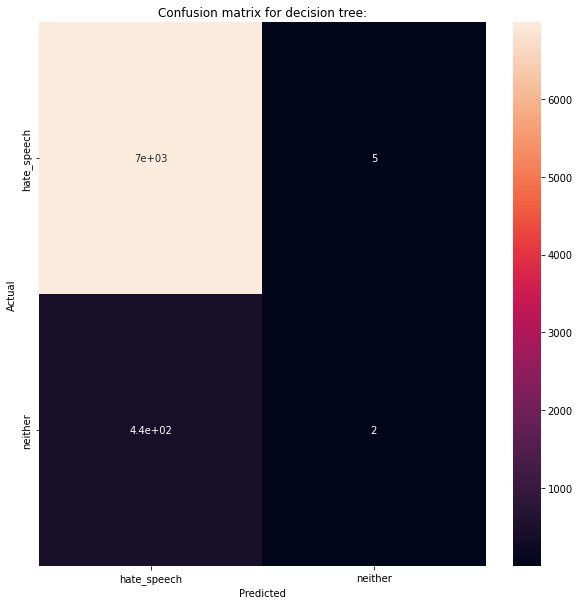

In [216]:
labels_for_cm = ["hate_speech", "neither"]
decision_tree_preds, y_test_decision = decision_tree_classifier(df_dav_hs, labels_davidson, label_davidson, "heatmap")
print(type(y_test_decision))
confusion_matrix_func(y_test_decision, decision_tree_preds, labels_for_cm, "Confusion matrix for decision tree:")

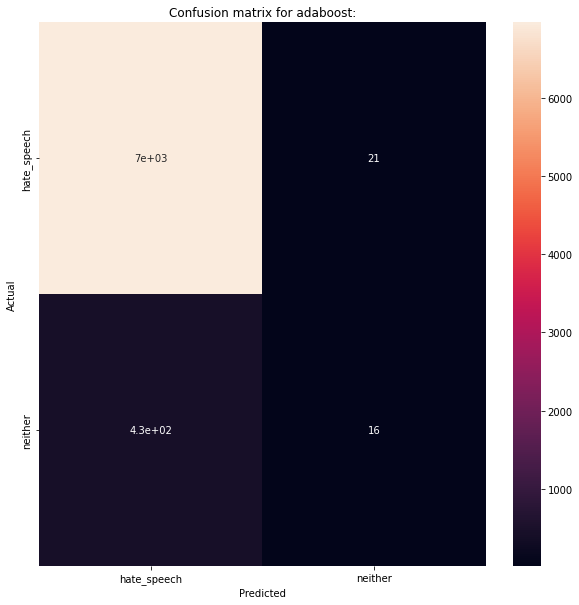

In [217]:
adaboost_preds, y_test_adaboost = adaboost_classifier(df_dav_hs, labels_davidson, label_davidson, "heatmap")
confusion_matrix_func(y_test_adaboost, adaboost_preds, labels_for_cm, "Confusion matrix for adaboost:")

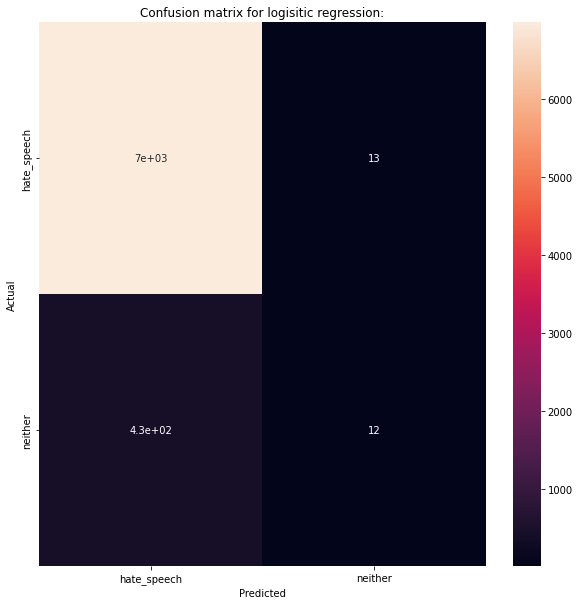

In [218]:
logistic_preds, y_test_logistic = logisitic_regression_classifier(df_dav_hs, labels_davidson, label_davidson, "heatmap")
confusion_matrix_func(y_test_logistic, logistic_preds, labels_for_cm, "Confusion matrix for logisitic regression:")

We can notice that the models do a pretty good job detecting hs-hs pairs but also have a substantial number of neither - hs pairs where they predict that something is hate speech when it actually is not. 

Let's take a look at sexism prediction for Waseem. 

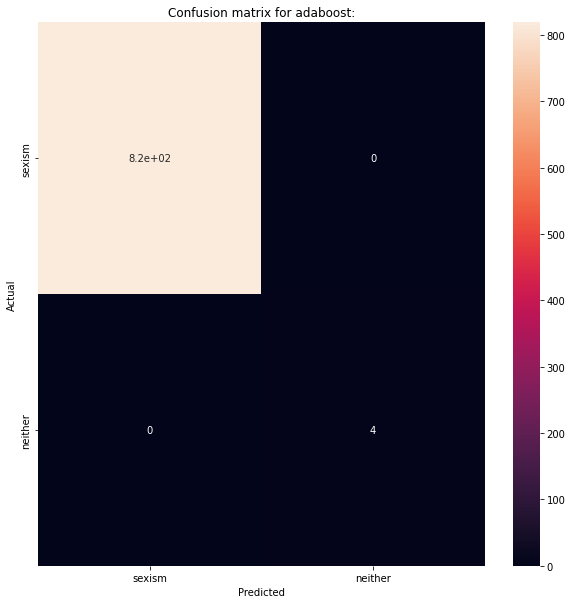

In [219]:
labels_for_cm = ["sexism", "neither"]
adaboost_preds, y_test_adaboost = adaboost_classifier(df_was_sexism, labels_waseem, label_waseem, "heatmap")
confusion_matrix_func(y_test_adaboost, adaboost_preds, labels_for_cm, "Confusion matrix for adaboost:")

We can notice that here Adaboost model is doing very well in predicting if a tweet is sexist or not. 

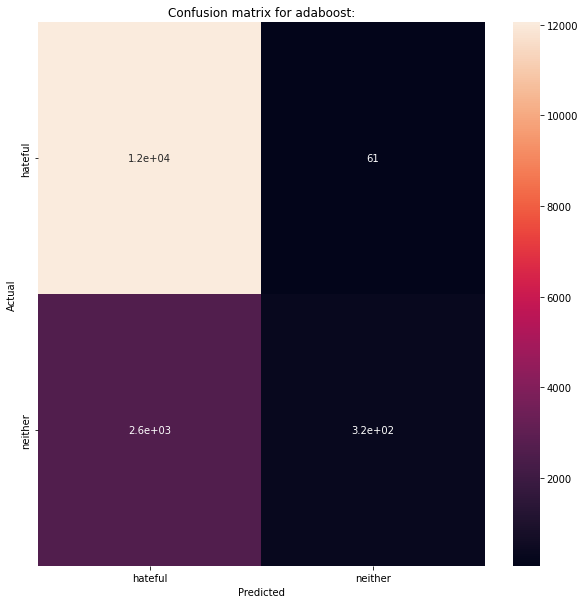

In [220]:
# Heatmap for Founta
labels_for_cm = ["hateful", "neither"]
adaboost_preds, y_test_adaboost = adaboost_classifier(df_was_hateful, labels_founta, label_founta, "heatmap")
confusion_matrix_func(y_test_adaboost, adaboost_preds, labels_for_cm, "Confusion matrix for adaboost:")

# Data Analysis of the Results 

First, we will just print the results that we got in order starting with overall Davidson.

In [221]:
def print_metrics(d, line):
  print(line)
  print(' ')
  for key in d:
    if (key == 'Linear Regression') :
      print(key)
      print(' ')
      print('MSE ', d[key][0])
      print('R2 ', d[key][1])
      print('RMSE ', d[key][2])
      print(' ')
    else: 
      print(key)
      print(' ')
      print('Precision ', d[key][0])
      print('Recall ', d[key][1])
      print('F-1 Score ', d[key][2])
      print(' ')

In [222]:
print_metrics(davidson_overall_dict, 'Davidson dataset')

Davidson dataset
 
Decision Tree
 
Precision  [0.94570197 0.46153846]
Recall  [0.9990037  0.01466993]
F-1 Score  [0.97162237 0.02843602]
 
Adaboost
 
Precision  [0.94090539 0.43859649]
Recall  [0.99541153 0.05422993]
F-1 Score  [0.9673913 0.0965251]
 
Logistic Regression
 
Precision  [0.94547908 0.16      ]
Recall  [0.99701153 0.00980392]
F-1 Score  [0.97056175 0.01847575]
 
Linear Regression
 
MSE  2.9954030524887045e+18
R2  -5.426186680148602e+19
RMSE  1730723274.382333
 
Random Forest gini
 
Precision  [0.94608438 0.75      ]
Recall  [0.99943044 0.02912621]
F-1 Score  [0.97202604 0.05607477]
 
Random Forest entropy
 
Precision  [0.94640929 0.25925926]
Recall  [0.99715545 0.01732673]
F-1 Score  [0.97111988 0.0324826 ]
 
K means k = 3
 
Precision  [0.97272727 0.01813785 0.        ]
Recall  [0.32159725 0.03348214 0.        ]
F-1 Score  [0.48338174 0.02352941 0.        ]
 
K means k = 5
 
Precision  [0.98119658 0.02266895 0.         0.         0.        ]
Recall  [0.08178968 0.12709832 

In [223]:
print_metrics(davidson_hs_dict, "Davidson Hate Speech")

Davidson Hate Speech
 
Decision Tree
 
Precision  [0.93847814 0.47826087]
Recall  [0.99827784 0.0235546 ]
F-1 Score  [0.9674548  0.04489796]
 
Adaboost
 
Precision  [0.94674075 0.42857143]
Recall  [0.9954403  0.05755396]
F-1 Score  [0.97047996 0.10147992]
 
Logistic Regression
 
Precision  [0.94502971 0.4516129 ]
Recall  [0.99757628 0.03325416]
F-1 Score  [0.97059232 0.0619469 ]
 
Linear Regression
 
MSE  35542408.941428855
R2  -637007560.6856102
RMSE  5961.745460972722
 
Random Forest gini
 
Precision  [0.94547908 0.56      ]
Recall  [0.99843238 0.03349282]
F-1 Score  [0.97123449 0.06320542]
 
Random Forest entropy
 
Precision  [0.94470668 0.35      ]
Recall  [0.99814762 0.01678657]
F-1 Score  [0.97069216 0.03203661]
 
K manes k = 3
 
Precision  [0.97551546 0.07411737 0.        ]
Recall  [0.32240204 0.81074169 0.        ]
F-1 Score  [0.48463508 0.13581834 0.        ]
 
K means k = 5
 
Precision  [0.98058252 0.0207433  0.         0.         0.        ]
Recall  [0.08628791 0.11650485 0.

In [224]:
print_metrics(davidson_ol_dict, "Davidson Offensive Language")

Davidson Offensive Language
 
Decision Tree
 
Precision  [0.94160486 0.55      ]
Recall  [0.99871263 0.02477477]
F-1 Score  [0.96931834 0.04741379]
 
Adaboost
 
Precision  [0.94485842 0.38888889]
Recall  [0.99529042 0.04906542]
F-1 Score  [0.96941896 0.08713693]
 
Logistic Regression
 
Precision  [0.9451203  0.45945946]
Recall  [0.99714775 0.04018913]
F-1 Score  [0.9704372  0.07391304]
 
Linear Regression
 
MSE  3.0219490723911876e+16
R2  -5.175004328057485e+17
RMSE  173837541.18116108
 
Random Forest gini
 
Precision  [0.94448197 0.40625   ]
Recall  [0.99728997 0.03066038]
F-1 Score  [0.97016789 0.05701754]
 
Random Forest entropy
 
Precision  [0.9463441  0.41666667]
Recall  [0.99700982 0.03640777]
F-1 Score  [0.9710165  0.06696429]
 
K means k = 3
 
Precision  [0.92008437 0.01385681 0.        ]
Recall  [0.55751207 0.03053435 0.        ]
F-1 Score  [0.69431426 0.01906275 0.        ]
 
K means k = 5
 
Precision  [0.98233216 0.01809409 0.         0.         0.        ]
Recall  [0.079621

In [225]:
print_metrics(waseem_overall_dict, "Waseem dataset")

Waseem dataset
 
Decision Tree
 
Precision  [0.99878049 1.        ]
Recall  [1.   0.75]
F-1 Score  [0.99938987 0.85714286]
 
Adaboost
 
Precision  [1. 1.]
Recall  [1. 1.]
F-1 Score  [1. 1.]
 
Logistic Regression
 
Precision  [1. 1.]
Recall  [1. 1.]
F-1 Score  [1. 1.]
 
Linear Regression
 
MSE  0.002428523952646414
R2  -0.0017720464811470382
RMSE  0.049280056337695215
 
Random Forest gini
 
Precision  [1.  0.8]
Recall  [0.998779 1.      ]
F-1 Score  [0.99938913 0.88888889]
 
Random Forest entropy
 
Precision  [1. 1.]
Recall  [1. 1.]
F-1 Score  [1. 1.]
 
K means k = 3
 
Precision  [1.         0.01992032 0.        ]
Recall  [0.3594132 1.        0.       ]
F-1 Score  [0.52877698 0.0390625  0.        ]
 
K means k = 2
 
Precision  [0.98820755 0.        ]
Recall  [0.51222494 0.        ]
F-1 Score  [0.6747182 0.       ]
 
Ensemble 1
 
Precision  [1.   0.75]
Recall  [0.99878049 1.        ]
F-1 Score  [0.99938987 0.85714286]
 
Ensemble 2
 
Precision  [1. 1.]
Recall  [1. 1.]
F-1 Score  [1. 1.]
 

In [226]:
print_metrics(waseem_sexism_dict, "Waseem Sexism")

Waseem Sexism
 
Decision Tree
 
Precision  [1. 1.]
Recall  [1. 1.]
F-1 Score  [1. 1.]
 
Adaboost
 
Precision  [1. 1.]
Recall  [1. 1.]
F-1 Score  [1. 1.]
 
Logistic Regression
 
Precision  [1. 1.]
Recall  [1. 1.]
F-1 Score  [1. 1.]
 
Linear Regression
 
MSE  0.004767757810989797
R2  0.014242786825425013
RMSE  0.06904895228017437
 
Random Forest gini
 
Precision  [1. 1.]
Recall  [1. 1.]
F-1 Score  [1. 1.]
 
Random Forest entropy
 
Precision  [1. 1.]
Recall  [1. 1.]
F-1 Score  [1. 1.]
 
K means k = 3
 
Precision  [1.         0.01509434 0.        ]
Recall  [0.33211233 1.         0.        ]
F-1 Score  [0.49862511 0.02973978 0.        ]
 
K means k = 2
 
Precision  [1.         0.00779221]
Recall  [0.53414634 1.        ]
F-1 Score  [0.6963434  0.01546392]
 
Ensemble 1
 
Precision  [1. 1.]
Recall  [1. 1.]
F-1 Score  [1. 1.]
 
Ensemble 2
 
Precision  [1. 1.]
Recall  [1. 1.]
F-1 Score  [1. 1.]
 
Ensemble 3
 
Precision  [1. 1.]
Recall  [1. 1.]
F-1 Score  [1. 1.]
 


In [227]:
print_metrics(waseem_racism_dict, "Waseem Racism")

Waseem Racism
 
Decision Tree
 
Precision  [1.   0.75]
Recall  [0.99878049 1.        ]
F-1 Score  [0.99938987 0.85714286]
 
Adaboost
 
Precision  [1.         0.66666667]
Recall  [0.99878197 1.        ]
F-1 Score  [0.99939062 0.8       ]
 
Logistic Regression
 
Precision  [1. 1.]
Recall  [1. 1.]
F-1 Score  [1. 1.]
 
Linear Regression
 
MSE  0.003591647117170967
R2  0.011086686899881015
RMSE  0.059930352219647154
 
Random forest gini
 
Precision  [1. 1.]
Recall  [1. 1.]
F-1 Score  [1. 1.]
 
Random Forest entropy
 
Precision  [1. 1.]
Recall  [1. 1.]
F-1 Score  [1. 1.]
 
K means k = 2
 
Precision  [1.         0.01005025]
Recall  [0.51892552 1.        ]
F-1 Score  [0.68327974 0.0199005 ]
 
Ensemble 1
 
Precision  [0.99392467 0.        ]
Recall  [1. 0.]
F-1 Score  [0.99695308 0.        ]
 
Ensemble 2
 
Precision  [1. 1.]
Recall  [1. 1.]
F-1 Score  [1. 1.]
 
Ensemble 3
 
Precision  [0.99877751 0.8       ]
Recall  [0.99877751 0.8       ]
F-1 Score  [0.99877751 0.8       ]
 


In [228]:
print_metrics(founta_overall_dict, "Founta Dataset")

Founta Dataset
 
Decision Tree
 
Precision  [0.8252679  0.85488127]
Recall  [0.99547176 0.11234397]
F-1 Score  [0.90241445 0.19859025]
 
Adaboost
 
Precision  [0.82545753 0.84715026]
Recall  [0.99514283 0.11342352]
F-1 Score  [0.90239259 0.20006118]
 
Logistic Regression
 
Precision  [0.81914458 0.84517766]
Recall  [0.99493776 0.11174497]
F-1 Score  [0.89852357 0.19739182]
 
Linear Regression
 
MSE  0.1446757621141615
R2  0.07310280585240736
RMSE  0.3803626718201479
 
Random Forest gini
 
Precision  [0.82635468 0.81400966]
Recall  [0.99366516 0.11721739]
F-1 Score  [0.90231967 0.20492551]
 
Random Forest entropy
 
Precision  [0.82649368 0.85714286]
Recall  [0.9954766  0.11494253]
F-1 Score  [0.90314878 0.2027027 ]
 
K means k = 3
 
Precision  [0.81922867 0.21929825 0.        ]
Recall  [0.99044402 0.00864753 0.        ]
F-1 Score  [0.8967369  0.01663894 0.        ]
 
K means k = 4
 
Precision  [0.8241299  0.86259542 0.         0.        ]
Recall  [0.98687341 0.07954945 0.         0.    

In [229]:
print_metrics(founta_abusive_dict, "Founta Abusive")

Founta Abusive
 
Decision Tree
 
Precision  [0.82462967 0.86089239]
Recall  [0.99563175 0.11322057]
F-1 Score  [0.90209842 0.20012203]
 
Adaboost
 
Precision  [0.8265892 0.8625   ]
Recall  [0.99547251 0.11970854]
F-1 Score  [0.90320412 0.21023766]
 
Logistic Regression
 
Precision  [0.8255148  0.84615385]
Recall  [0.99539587 0.10742937]
F-1 Score  [0.90253084 0.19065305]
 
Linear Regression
 
MSE  0.1444054658182865
R2  0.07483451871552893
RMSE  0.38000719179811127
 
Random Forest gini
 
Precision  [0.82491283 0.8337469 ]
Recall  [0.99447787 0.11598205]
F-1 Score  [0.90179372 0.20363636]
 
Random Forest entropy
 
Precision  [0.82622368 0.85074627]
Recall  [0.9950601 0.1185853]
F-1 Score  [0.90281616 0.20815581]
 
K means k = 3
 
Precision  [0.81798335 0.87937743 0.        ]
Recall  [0.98951886 0.07758325 0.        ]
F-1 Score  [0.89561158 0.14258675 0.        ]
 
K means k = 4
 
Precision  [0.82030338 0.86037736 0.         0.        ]
Recall  [0.98483725 0.07875648 0.         0.       

In [230]:
print_metrics(founta_hateful_dict, "Founta Hateful")

Founta Hateful
 
Decision Tree
 
Precision  [0.8215309  0.87634409]
Recall  [0.99619457 0.11080897]
F-1 Score  [0.9004711 0.1967411]
 
Adaboost
 
Precision  [0.82769924 0.83204134]
Recall  [0.99466557 0.11318102]
F-1 Score  [0.90353362 0.19925743]
 
Logistic Regression
 
Precision  [0.82143101 0.84130982]
Recall  [0.99478606 0.1133356 ]
F-1 Score  [0.8998353  0.19976077]
 
Linear Regression
 
MSE  0.1447173227944432
R2  0.0625025801329625
RMSE  0.38041730086109804
 
Random Forest gini
 
Precision  [0.8169591  0.85117493]
Recall  [0.99525909 0.1084137 ]
F-1 Score  [0.89733783 0.19233038]
 
Random Forest entropy
 
Precision  [0.82821582 0.80589681]
Recall  [0.99351928 0.11549296]
F-1 Score  [0.90336777 0.20203265]
 
K means k = 3
 
Precision  [0.81712884 0.86486486 0.        ]
Recall  [0.99091134 0.07652887 0.        ]
F-1 Score  [0.89566841 0.14061519 0.        ]
 
K means k = 4
 
Precision  [0.8224145  0.31578947 0.         0.        ]
Recall  [0.98503043 0.01253482 0.         0.      

In [231]:
# TODO (Zach): data analysis of the results

In [232]:
# TODO (Zach): BERT in AWS (probably not in this notebook, add it separately on github but
# include results in data analysis section)